In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error 
from lightgbm import LGBMRegressor
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser, DecisionTreeDiscretiser
import shap
warnings.filterwarnings('ignore')
from sklearn import set_config 


set_config(transform_output="pandas")

In [4]:
df = pd.read_csv('alt_fuel_stations_historical_day.csv', engine='python')
pd.set_option('display.max_columns', None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112833 entries, 0 to 112832
Data columns (total 75 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Fuel Type Code                           112833 non-null  object 
 1   Station Name                             112832 non-null  object 
 2   Street Address                           112798 non-null  object 
 3   Intersection Directions                  29087 non-null   object 
 4   City                                     112829 non-null  object 
 5   State                                    112833 non-null  object 
 6   ZIP                                      112831 non-null  object 
 7   Plus4                                    0 non-null       float64
 8   Station Phone                            103807 non-null  object 
 9   Status Code                              112833 non-null  object 
 10  Expected Date                   

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.isna().sum()

Fuel Type Code                                  0
Station Name                                    1
Street Address                                 35
Intersection Directions                     83746
City                                            4
                                            ...  
CNG Station Sells Renewable Natural Gas    111881
LNG Station Sells Renewable Natural Gas    112778
Maximum Vehicle Class                       85226
EV Workplace Charging                       13583
Funding Sources                            111466
Length: 75, dtype: int64

In [8]:
df.columns

Index(['Fuel Type Code', 'Station Name', 'Street Address',
       'Intersection Directions', 'City', 'State', 'ZIP', 'Plus4',
       'Station Phone', 'Status Code', 'Expected Date',
       'Groups With Access Code', 'Access Days Time', 'Cards Accepted',
       'BD Blends', 'NG Fill Type Code', 'NG PSI', 'EV Level1 EVSE Num',
       'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 'EV Network',
       'EV Network Web', 'Geocode Status', 'Latitude', 'Longitude',
       'Date Last Confirmed', 'ID', 'Updated At', 'Owner Type Code',
       'Federal Agency ID', 'Federal Agency Name', 'Open Date',
       'Hydrogen Status Link', 'NG Vehicle Class', 'LPG Primary',
       'E85 Blender Pump', 'EV Connector Types', 'Country',
       'Intersection Directions (French)', 'Access Days Time (French)',
       'BD Blends (French)', 'Groups With Access Code (French)',
       'Hydrogen Is Retail', 'Access Code', 'Access Detail Code',
       'Federal Agency Code', 'Facility Type', 'CNG Dispenser N

In [9]:
# kolom yang di buang karena ga relevan
columns_to_drop = [
    'Station Name', 'Street Address', 'Intersection Directions', 'Plus4', 
    'Station Phone', 'Expected Date', 'Groups With Access Code', 'Access Days Time', 
    'Cards Accepted', 'BD Blends', 'NG Fill Type Code', 'NG PSI', 'EV Other Info', 
    'EV Network Web', 'Geocode Status', 'Date Last Confirmed', 'ID', 'Updated At', 
    'Federal Agency ID', 'Federal Agency Name', 'Hydrogen Status Link', 
    'NG Vehicle Class', 'LPG Primary', 'E85 Blender Pump', 
    'Intersection Directions (French)', 'Access Days Time (French)', 
    'BD Blends (French)', 'Groups With Access Code (French)', 'Hydrogen Is Retail', 
    'Access Detail Code', 'Federal Agency Code', 'CNG Dispenser Num', 
    'CNG On-Site Renewable Source', 'CNG Total Compression Capacity', 
    'CNG Storage Capacity', 'LNG On-Site Renewable Source', 'E85 Other Ethanol Blends', 
    'EV Pricing (French)', 'LPG Nozzle Types', 'Hydrogen Pressures', 'Hydrogen Standards', 
    'CNG Fill Type Code', 'CNG PSI', 'CNG Vehicle Class', 'LNG Vehicle Class', 
    'RD Blends', 'RD Blends (French)', 'RD Blended with Biodiesel', 
    'RD Maximum Biodiesel Level', 'NPS Unit Name', 
    'CNG Station Sells Renewable Natural Gas', 'LNG Station Sells Renewable Natural Gas'
]

df.drop(columns=columns_to_drop, inplace=True)


In [10]:
df.shape

(112833, 23)

In [11]:
print('jumlah kolom setelah dibuang : ', df.shape[1])

jumlah kolom setelah dibuang :  23


In [12]:
print(df.head())

  Fuel Type Code         City State    ZIP Status Code  EV Level1 EVSE Num  \
0            CNG   Montgomery    AL  36107           E                 NaN   
1            CNG      Atlanta    GA  30324           E                 NaN   
2            CNG   Fort Smith    AR  72903           E                 NaN   
3            CNG  East Boston    MA  02128           E                 NaN   
4            CNG      Everett    MA  02149           E                 NaN   

   EV Level2 EVSE Num  EV DC Fast Count EV Network   Latitude  Longitude  \
0                 NaN               NaN        NaN  32.367916 -86.267021   
1                 NaN               NaN        NaN  33.821911 -84.367461   
2                 NaN               NaN        NaN  35.362213 -94.375338   
3                 NaN               NaN        NaN  42.374706 -71.026549   
4                 NaN               NaN        NaN  42.393167 -71.064352   

  Owner Type Code   Open Date EV Connector Types Country Access Code  \
0 

In [13]:
df['Fuel Type Code'].unique()

array(['CNG', 'E85', 'ELEC', 'LNG', 'LPG', 'BD', 'HY', 'RD'], dtype=object)

In [14]:
df['Status Code'].unique()

array(['E', 'T', 'P'], dtype=object)

In [15]:
df['Country'].unique()

array(['US', 'CA'], dtype=object)

In [16]:
df_ev = df[
    (df['Fuel Type Code'] == 'ELEC') &
    (df['Status Code'] == 'E') &
    (df['Country'] == 'US')
].copy()

In [17]:
print('dimensi data setelah di filter :', df_ev.shape)
df_ev.info()

dimensi data setelah di filter : (81370, 23)
<class 'pandas.core.frame.DataFrame'>
Index: 81370 entries, 123 to 112831
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Fuel Type Code               81370 non-null  object 
 1   City                         81367 non-null  object 
 2   State                        81370 non-null  object 
 3   ZIP                          81368 non-null  object 
 4   Status Code                  81370 non-null  object 
 5   EV Level1 EVSE Num           593 non-null    float64
 6   EV Level2 EVSE Num           68798 non-null  float64
 7   EV DC Fast Count             13813 non-null  float64
 8   EV Network                   81369 non-null  object 
 9   Latitude                     81370 non-null  float64
 10  Longitude                    81370 non-null  float64
 11  Owner Type Code              21798 non-null  object 
 12  Open Date                    81

In [18]:
df_ev['Open Date'].head().dtypes

dtype('O')

In [19]:
# hitung jumlah stasiun per zip code
target_df = df_ev.groupby('ZIP').size().reset_index(name='jumlah_stasiun')
target_df.head()

,ZIP,jumlah_stasiun
0,0000,1
1,00000,3
2,00214,1
3,00603,1
4,00646,1


In [20]:
df_ev.isnull().mean() *100

Fuel Type Code                  0.000000
City                            0.003687
State                           0.000000
ZIP                             0.002458
Status Code                     0.000000
EV Level1 EVSE Num             99.271230
EV Level2 EVSE Num             15.450412
EV DC Fast Count               83.024456
EV Network                      0.001229
Latitude                        0.000000
Longitude                       0.000000
Owner Type Code                73.211257
Open Date                       0.380976
EV Connector Types              0.008603
Country                         0.000000
Access Code                     0.000000
Facility Type                  74.849453
EV Pricing                     81.185941
EV On-Site Renewable Source    99.453115
Restricted Access              13.052722
Maximum Vehicle Class          82.950719
EV Workplace Charging           0.000000
Funding Sources                99.852526
dtype: float64

In [21]:
df_ev['Open Date']

123       1999-10-15
124       1995-08-30
125       1999-10-15
126       2018-05-01
127       1999-10-15
             ...    
112822    2025-09-18
112823    2025-09-17
112824    2025-09-17
112826    2025-05-23
112831    2022-05-18
Name: Open Date, Length: 81370, dtype: object

In [22]:

df_ev['Open Date'] = pd.to_datetime(df_ev['Open Date'])
df_ev['station_age_days'] = (pd.to_datetime('today') - df_ev['Open Date']).dt.days
df_ev['facility_network_interaction'] = df_ev['Facility Type'].astype(str) + '_' + df_ev['EV Network'].astype(str)

df_ev

,Fuel Type Code,City,State,ZIP,Status Code,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV Network,Latitude,Longitude,Owner Type Code,Open Date,EV Connector Types,Country,Access Code,Facility Type,EV Pricing,EV On-Site Renewable Source,Restricted Access,Maximum Vehicle Class,EV Workplace Charging,Funding Sources,station_age_days,facility_network_interaction
123,ELEC,Sun Valley,CA,91352,E,NaN,57.0,2.0,Non-Networked,34.248319,-118.387971,LG,1999-10-15,CHADEMO J1772 J1772COMBO,US,private,UTILITY,NaN,NaN,NaN,NaN,True,NaN,9477.0,UTILITY_Non-Networked
124,ELEC,Los Angeles,CA,90015,E,NaN,7.0,NaN,Non-Networked,34.040539,-118.271387,P,1995-08-30,J1772,US,public,PARKING_GARAGE,Free; parking fee,NaN,False,LD,False,NaN,10984.0,PARKING_GARAGE_Non-Networked
125,ELEC,Los Angeles,CA,90012,E,NaN,338.0,12.0,Non-Networked,34.059133,-118.248589,LG,1999-10-15,CHADEMO J1772 J1772COMBO,US,private,UTILITY,NaN,NaN,NaN,LD,True,NaN,9477.0,UTILITY_Non-Networked
126,ELEC,Long Beach,CA,90803,E,NaN,19.0,1.0,Non-Networked,33.759802,-118.096665,LG,2018-05-01,CHADEMO J1772 J1772COMBO,US,private,UTILITY,NaN,NaN,NaN,NaN,True,NaN,2704.0,UTILITY_Non-Networked
127,ELEC,Wilmington,CA,90744,E,NaN,10.0,NaN,Non-Networked,33.770508,-118.265628,LG,1999-10-15,J1772,US,private,UTILITY,NaN,NaN,NaN,NaN,True,NaN,9477.0,UTILITY_Non-Networked
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112822,ELEC,Beaver,UT,84713,E,NaN,NaN,8.0,IONNA,38.292689,-112.646501,NaN,2025-09-18,J1772COMBO TESLA,US,public,NaN,NaN,NaN,False,NaN,False,NaN,7.0,nan_IONNA
112823,ELEC,Teaticket,MA,02536,E,NaN,NaN,4.0,RED_E,41.577910,-70.577920,NaN,2025-09-17,J1772COMBO,US,public,PUBLIC,NaN,NaN,False,NaN,False,NaN,8.0,PUBLIC_RED_E
112824,ELEC,Bristol,CT,06010,E,NaN,NaN,4.0,RED_E,41.682196,-72.951026,NaN,2025-09-17,J1772COMBO,US,public,PUBLIC,NaN,NaN,False,NaN,False,NaN,8.0,PUBLIC_RED_E
112826,ELEC,Jamaica Plain,MA,02130,E,NaN,10.0,NaN,AMPUP,42.322760,-71.111050,P,2025-05-23,J1772,US,public,HOSPITAL,$0.30 per kWh,NaN,False,LD,False,NaN,125.0,HOSPITAL_AMPUP


In [23]:
add_agg_col = df_ev.groupby('ZIP').agg(
    total_level2=('EV Level2 EVSE Num', 'sum'),
    total_dc_fast=('EV DC Fast Count', 'sum'),
    dominant_facility_type=('Facility Type', lambda x : x.mode().iloc[0] if not x.mode().empty else None),
    dominant_ev_network=('EV Network', lambda x : x.mode().iloc[0] if not x.mode().empty else None), 
    dominant_interaction=('facility_network_interaction', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    avg_station_age_days=('station_age_days', 'mean'),
    last_station_opened_days_ago=('station_age_days', 'min'),
    new_station_last_2_years=('Open Date', lambda x: (x > (pd.to_datetime('today') - pd.DateOffset(years=2))).sum()),
).reset_index()

add_agg_col

,ZIP,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years
0,0000,1.0,0.0,None,EV Connect,nan_EV Connect,163.000000,163.0,1
1,00000,1.0,8.0,HOTEL,UNIVERSAL,HOTEL_UNIVERSAL,214.333333,163.0,3
2,00214,8.0,0.0,None,Non-Networked,nan_Non-Networked,2606.000000,2606.0,0
3,00603,2.0,0.0,None,Blink Network,nan_Blink Network,505.000000,505.0,1
4,00646,2.0,0.0,PARKING_LOT,SWTCH,PARKING_LOT_SWTCH,620.000000,620.0,1
...,...,...,...,...,...,...,...,...,...
12216,99801,26.0,4.0,LIBRARY,Non-Networked,LIBRARY_Non-Networked,2491.111111,1029.0,0
12217,99835,1.0,0.0,FED_GOV,Non-Networked,FED_GOV_Non-Networked,1714.000000,1714.0,0
12218,99840,5.0,0.0,MUNI_GOV,Non-Networked,MUNI_GOV_Non-Networked,1739.000000,1739.0,0
12219,99926,2.0,0.0,None,ChargePoint Network,nan_ChargePoint Network,116.000000,116.0,1


In [24]:
final_df = pd.merge(target_df, add_agg_col, on='ZIP', how='left')
final_df

,ZIP,jumlah_stasiun,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years
0,0000,1,1.0,0.0,None,EV Connect,nan_EV Connect,163.000000,163.0,1
1,00000,3,1.0,8.0,HOTEL,UNIVERSAL,HOTEL_UNIVERSAL,214.333333,163.0,3
2,00214,1,8.0,0.0,None,Non-Networked,nan_Non-Networked,2606.000000,2606.0,0
3,00603,1,2.0,0.0,None,Blink Network,nan_Blink Network,505.000000,505.0,1
4,00646,1,2.0,0.0,PARKING_LOT,SWTCH,PARKING_LOT_SWTCH,620.000000,620.0,1
...,...,...,...,...,...,...,...,...,...,...
12216,99801,18,26.0,4.0,LIBRARY,Non-Networked,LIBRARY_Non-Networked,2491.111111,1029.0,0
12217,99835,1,1.0,0.0,FED_GOV,Non-Networked,FED_GOV_Non-Networked,1714.000000,1714.0,0
12218,99840,1,5.0,0.0,MUNI_GOV,Non-Networked,MUNI_GOV_Non-Networked,1739.000000,1739.0,0
12219,99926,1,2.0,0.0,None,ChargePoint Network,nan_ChargePoint Network,116.000000,116.0,1


In [25]:
X = final_df.drop(['jumlah_stasiun'], axis=1)
y = final_df['jumlah_stasiun']

In [26]:
X

,ZIP,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years
0,0000,1.0,0.0,None,EV Connect,nan_EV Connect,163.000000,163.0,1
1,00000,1.0,8.0,HOTEL,UNIVERSAL,HOTEL_UNIVERSAL,214.333333,163.0,3
2,00214,8.0,0.0,None,Non-Networked,nan_Non-Networked,2606.000000,2606.0,0
3,00603,2.0,0.0,None,Blink Network,nan_Blink Network,505.000000,505.0,1
4,00646,2.0,0.0,PARKING_LOT,SWTCH,PARKING_LOT_SWTCH,620.000000,620.0,1
...,...,...,...,...,...,...,...,...,...
12216,99801,26.0,4.0,LIBRARY,Non-Networked,LIBRARY_Non-Networked,2491.111111,1029.0,0
12217,99835,1.0,0.0,FED_GOV,Non-Networked,FED_GOV_Non-Networked,1714.000000,1714.0,0
12218,99840,5.0,0.0,MUNI_GOV,Non-Networked,MUNI_GOV_Non-Networked,1739.000000,1739.0,0
12219,99926,2.0,0.0,None,ChargePoint Network,nan_ChargePoint Network,116.000000,116.0,1


In [27]:
y

0         1
1         3
2         1
3         1
4         1
         ..
12216    18
12217     1
12218     1
12219     1
12220     1
Name: jumlah_stasiun, Length: 12221, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2)

for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

X_train.shape, X_test.shape

((9776, 9), (2445, 9))

In [29]:
# di gabungin biar lebih mudah di plotting
df_train = pd.concat([X_train, y_train], axis=1)
df_train

,ZIP,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years,jumlah_stasiun
0,95209,4.0,0.0,SCHOOL,Non-Networked,SCHOOL_Non-Networked,3384.000000,3384.0,0,2
1,95073,0.0,6.0,None,eVgo Network,nan_eVgo Network,138.000000,138.0,1,1
2,77407,16.0,0.0,None,Blink Network,nan_Blink Network,967.000000,444.0,3,6
3,72088,2.0,0.0,None,Tesla Destination,nan_Tesla Destination,451.000000,451.0,1,1
4,29615,26.0,6.0,HOTEL,ChargePoint Network,nan_ChargePoint Network,1133.928571,182.0,10,14
...,...,...,...,...,...,...,...,...,...,...
9771,98252,6.0,0.0,PARKING_LOT,Non-Networked,PARKING_LOT_Non-Networked,724.666667,84.0,1,3
9772,37615,5.0,0.0,MUSEUM,ChargePoint Network,nan_ChargePoint Network,1006.500000,296.0,2,4
9773,39701,13.0,2.0,HOTEL,ChargePoint Network,nan_ChargePoint Network,2061.333333,540.0,2,6
9774,06361,2.0,0.0,PAY_GARAGE,Non-Networked,PAY_GARAGE_Non-Networked,500.000000,500.0,1,1


In [30]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categoric_features = X_train.select_dtypes(include=['object']).columns.tolist()

print('numeric_features =', numeric_features)
print('categoric_features =', categoric_features)

numeric_features = ['total_level2', 'total_dc_fast', 'avg_station_age_days', 'last_station_opened_days_ago', 'new_station_last_2_years']
categoric_features = ['ZIP', 'dominant_facility_type', 'dominant_ev_network', 'dominant_interaction']


In [31]:
if 'ZIP' in categoric_features:
    categoric_features.remove('ZIP')

X_train = X_train.drop(columns=['ZIP'])
X_test = X_test.drop(columns=['ZIP'])

print('X_train =',X_train.columns)
print('X_test =',X_test.columns)

X_train = Index(['total_level2', 'total_dc_fast', 'dominant_facility_type',
       'dominant_ev_network', 'dominant_interaction', 'avg_station_age_days',
       'last_station_opened_days_ago', 'new_station_last_2_years'],
      dtype='object')
X_test = Index(['total_level2', 'total_dc_fast', 'dominant_facility_type',
       'dominant_ev_network', 'dominant_interaction', 'avg_station_age_days',
       'last_station_opened_days_ago', 'new_station_last_2_years'],
      dtype='object')


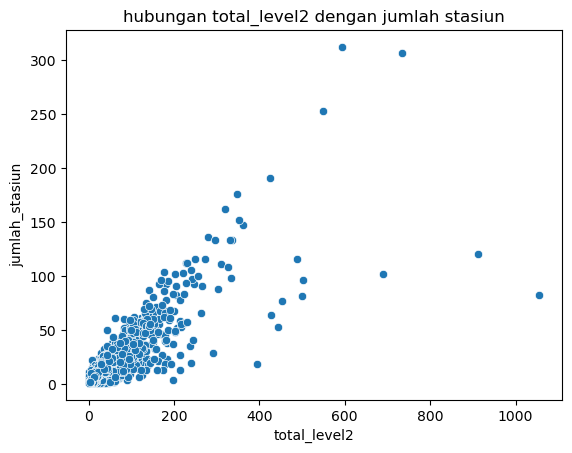

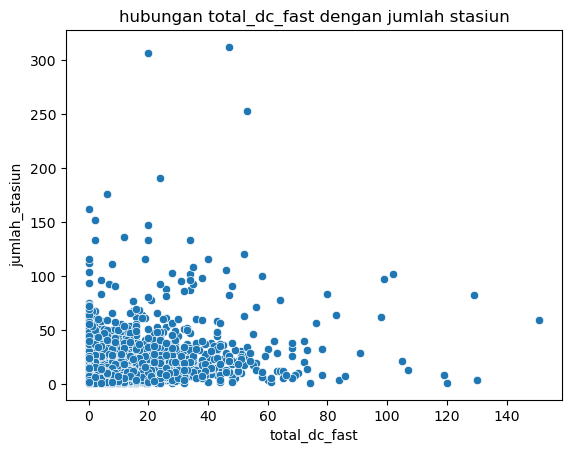

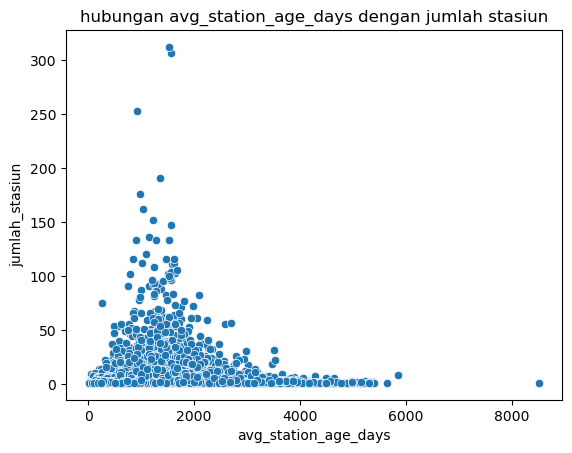

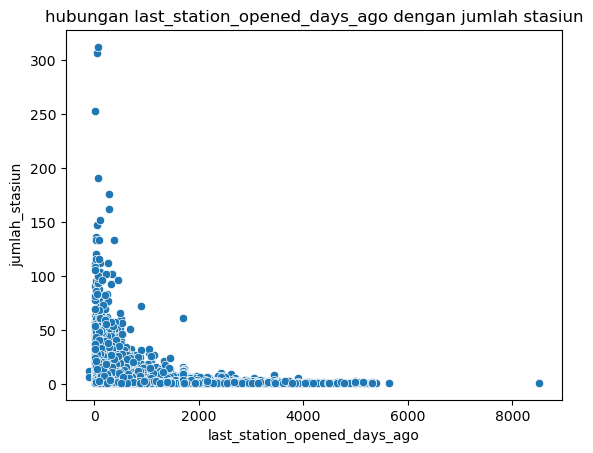

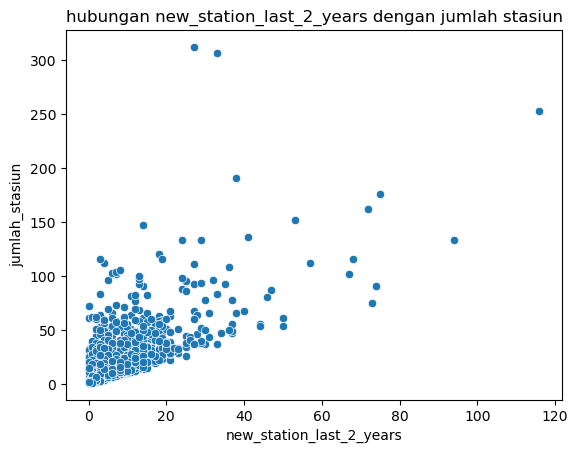

In [32]:
for col in numeric_features:
    sns.scatterplot(data=df_train, x=col, y='jumlah_stasiun')
    plt.title(f'hubungan {col} dengan jumlah stasiun')
    plt.show()
    print()

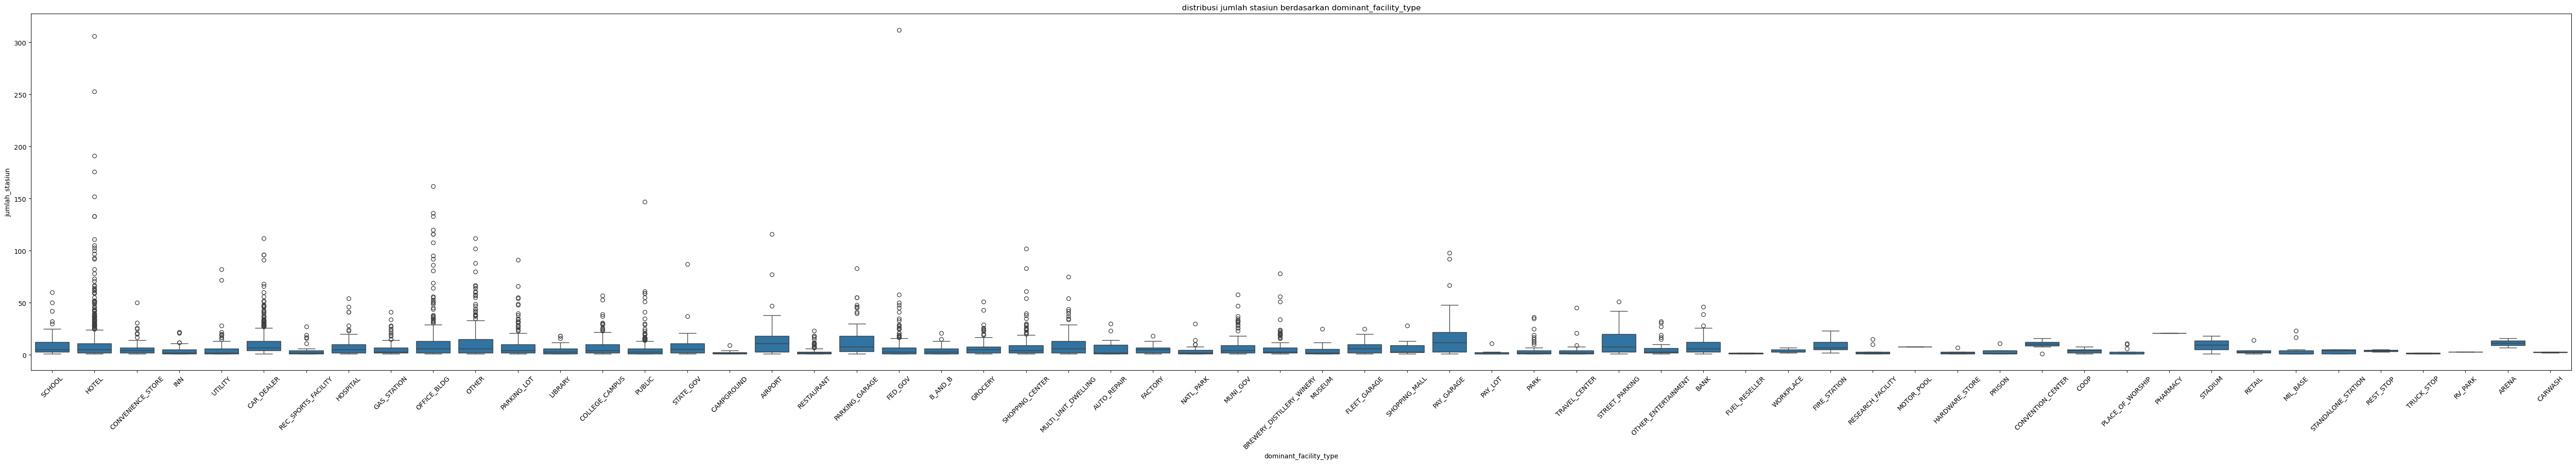

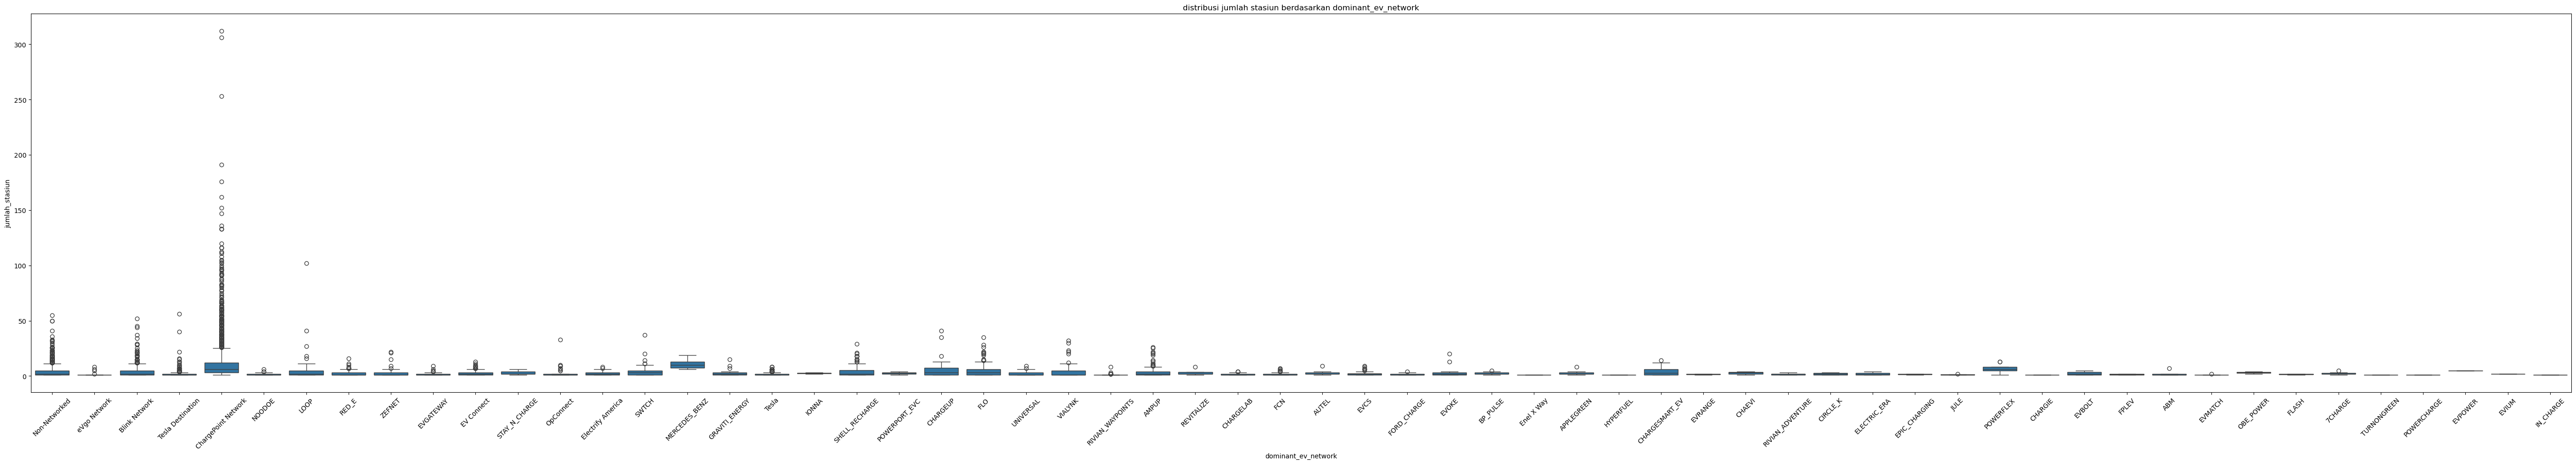

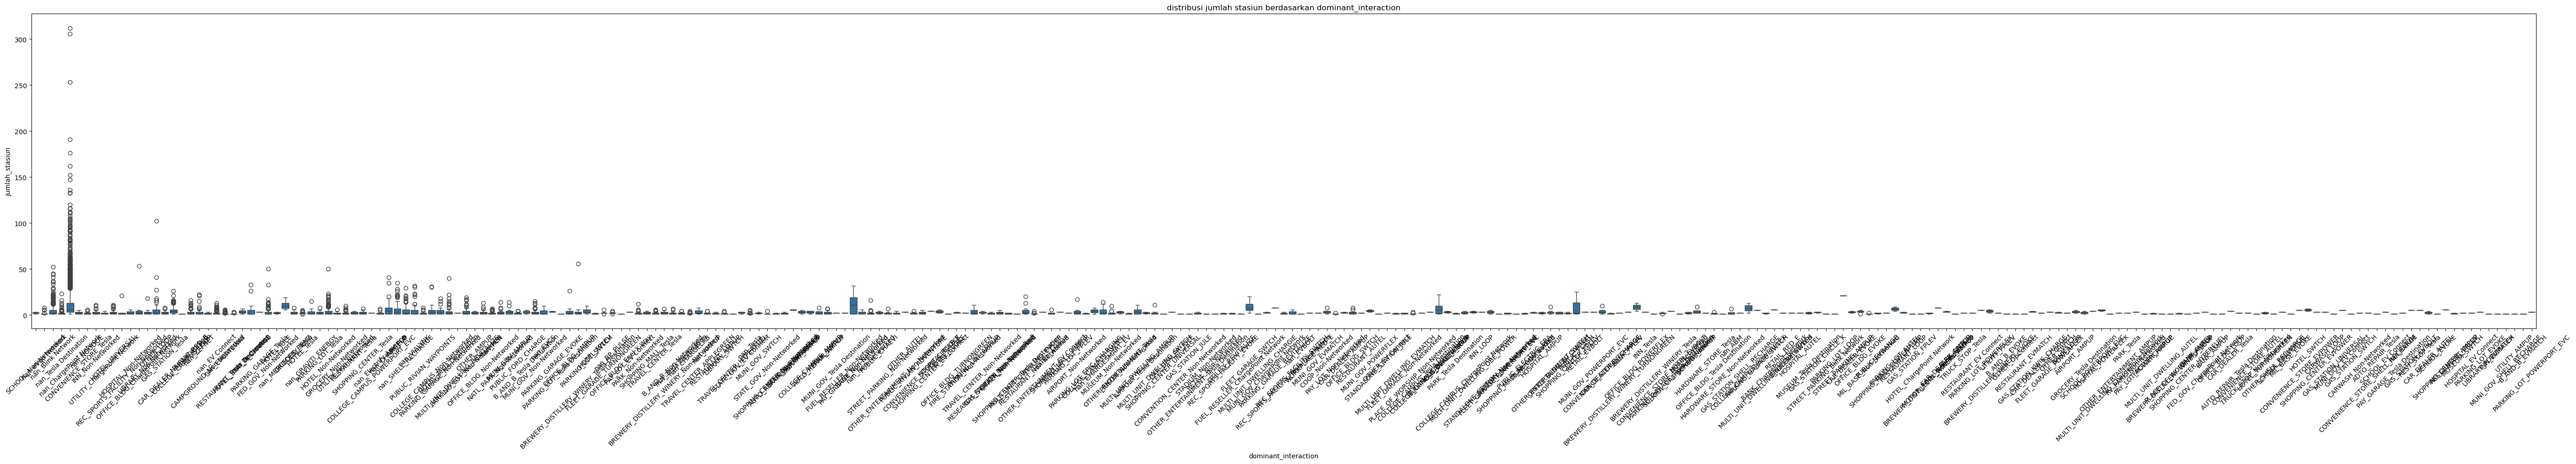

In [33]:
for col in categoric_features:
    plt.figure(figsize=(55,10))
    sns.boxplot(data=df_train, x=col, y='jumlah_stasiun')
    plt.title(f'distribusi jumlah stasiun berdasarkan {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

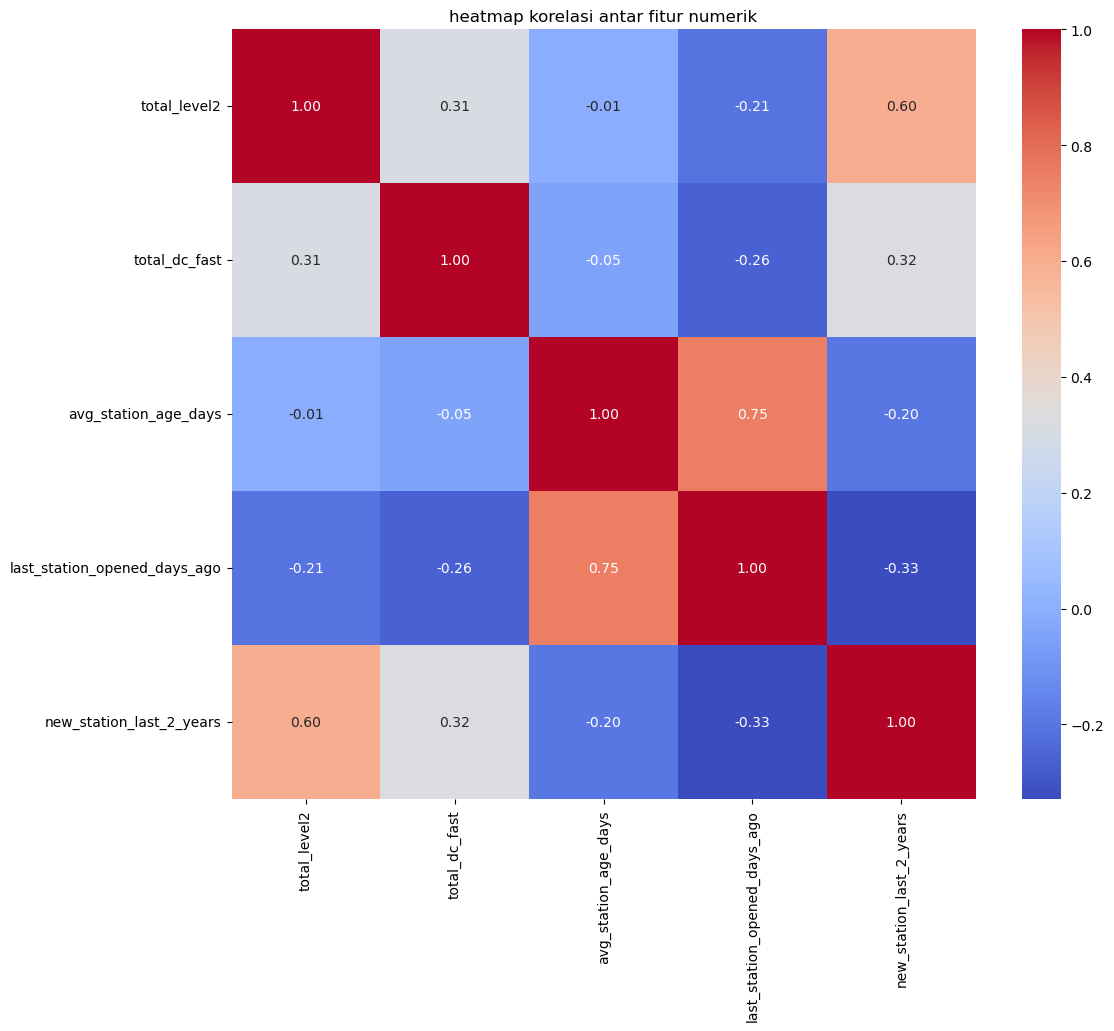

In [34]:
correlation_matrix = X_train[numeric_features].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('heatmap korelasi antar fitur numerik')
plt.show()

In [35]:
def correlation_selector(df, threshold):
    correlated_features = set()
    correlation_matrix = df.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)

numeric_train_df = X_train.select_dtypes(include=np.number)
features_to_drop = correlation_selector(numeric_train_df, 0.8)
X_train_no_corr = X_train.drop(columns=features_to_drop)
X_test_no_corr = X_test.drop(columns=features_to_drop)

print(f"Fitur yang dihapus karena korelasi tinggi: {features_to_drop}")


Fitur yang dihapus karena korelasi tinggi: []


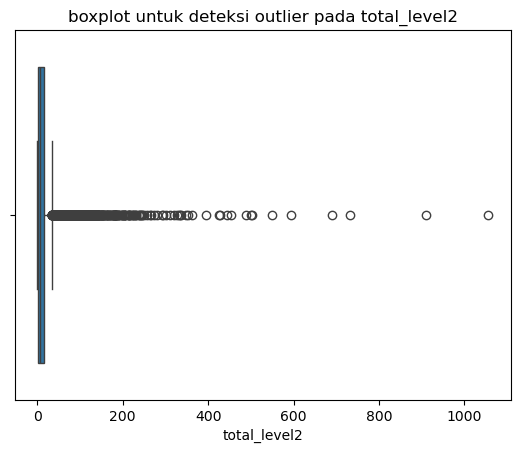

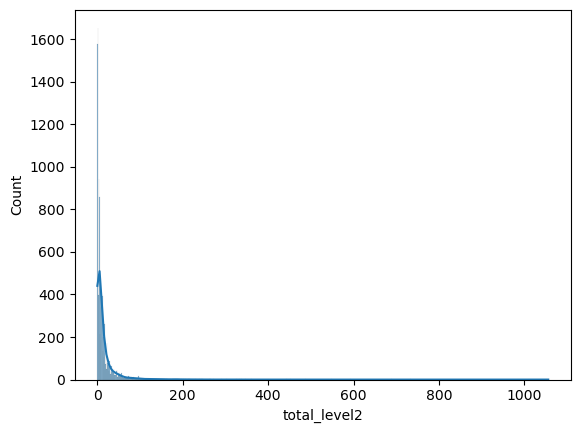

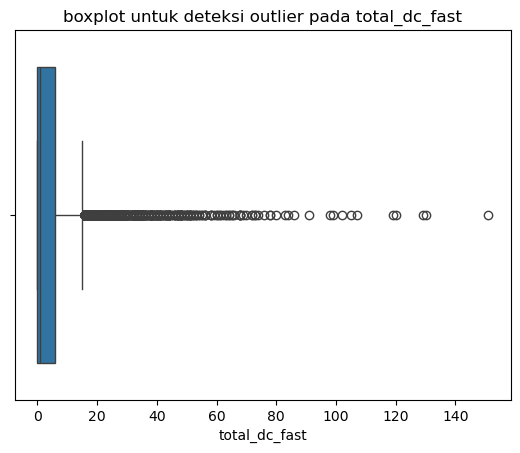

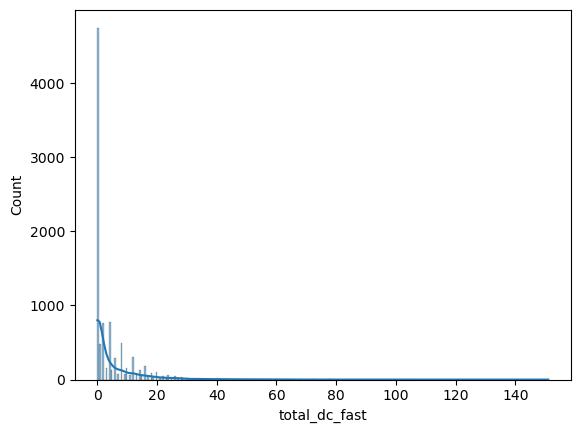

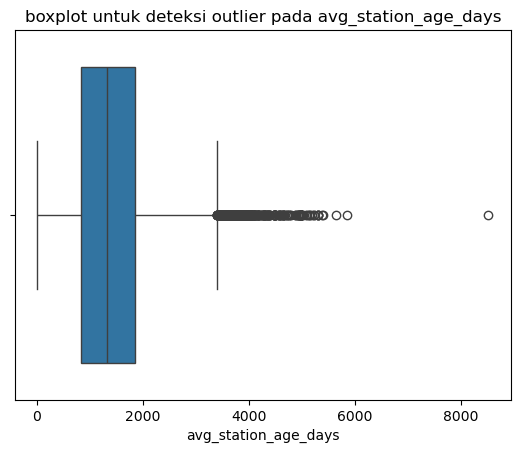

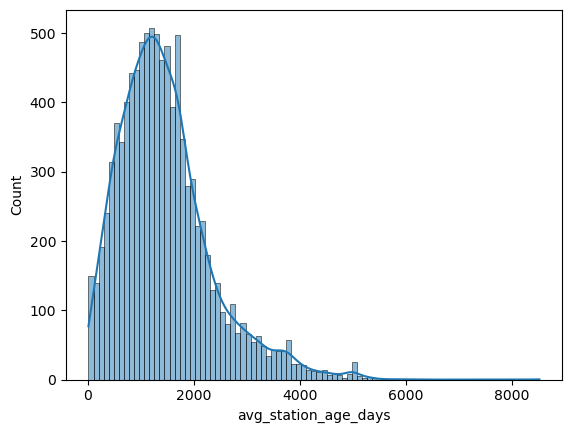

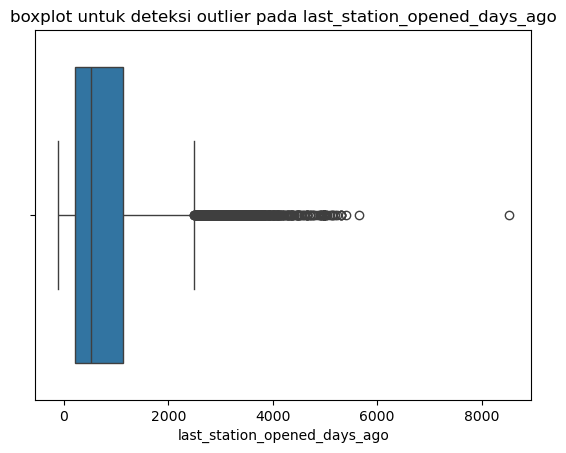

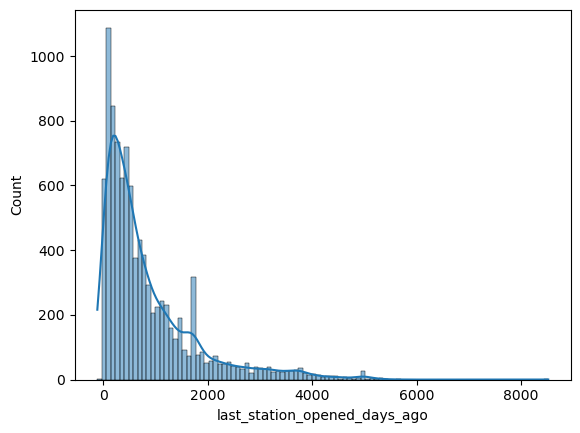

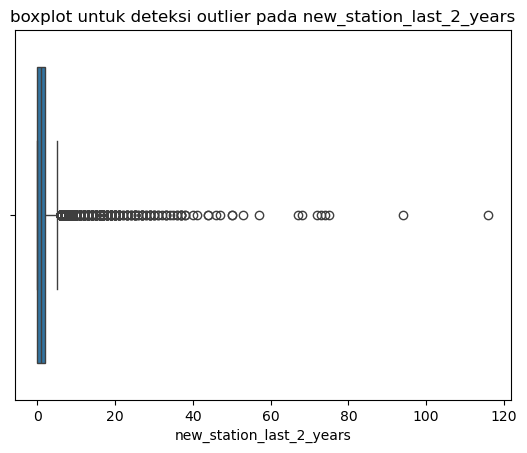

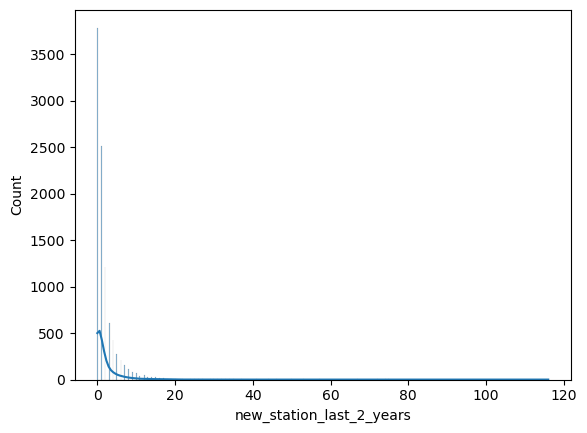

In [36]:
for col in numeric_features:
    sns.boxplot(x=X_train[col])
    plt.title(f'boxplot untuk deteksi outlier pada {col}')
    plt.show()

    sns.histplot(X_train[col], kde=True)
    plt.show()

## MACHINE LEARNING

In [37]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
], verbose_feature_names_out=False, n_jobs=-1, remainder='passthrough')




In [192]:
model_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selection_variance', VarianceThreshold(threshold=0.01)),
    ('selection_duplicate', DropDuplicateFeatures()),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model_pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selection_variance', VarianceThreshold(threshold=0.01)),
    ('selection_duplicate', DropDuplicateFeatures()),
    ('regressor', DecisionTreeRegressor())
])

model_pipeline_linreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selection_variance', VarianceThreshold(threshold=0.01)),
    ('selection_duplicate', DropDuplicateFeatures()),
    ('regressor', LinearRegression())
])

model_pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

print("Memulai training model pipeline (random forest)...")
model_pipeline_rf.fit(X_train, y_train)
print("Training selesai (random forest)!")

print("\nMemulai training model pipeline (decision tree)...")
model_pipeline_dt.fit(X_train, y_train)
print("Training selesai (decision tree)!")

print("\nMemulai training model pipeline (linear regression)...")
model_pipeline_linreg.fit(X_train, y_train)
print("Training selesai (linear regression)!")

print("\nMemulai training model pipeline (lasso)...")
model_pipeline_lasso.fit(X_train, y_train)
print("Training selesai (lasso)!")

Memulai training model pipeline (random forest)...
Training selesai (random forest)!

Memulai training model pipeline (decision tree)...
Training selesai (decision tree)!

Memulai training model pipeline (linear regression)...
Training selesai (linear regression)!

Memulai training model pipeline (lasso)...
Training selesai (lasso)!


In [181]:
model_pipeline_rf

,steps,"[('preprocessor', ...), ('selection_variance', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [193]:

y_pred_rf = model_pipeline_rf.predict(X_test)
y_pred_dt = model_pipeline_dt.predict(X_test)
y_pred_linreg = model_pipeline_linreg.predict(X_test)
y_pred_lasso = model_pipeline_lasso.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
r2_dt = r2_score(y_test, y_pred_dt)
r2_linreg = r2_score(y_test, y_pred_linreg)
r2_lasso = r2_score(y_test, y_pred_lasso)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(f"\nHasil Evaluasi Model (random forest):")
print(f"R-squared (R2) : {r2_rf:.4f}")
print(f"Root Mean Squared Error (RMSE) (random forest): {rmse_rf:.4f}")

print(f"\nHasil Evaluasi Model (decision tree):")
print(f"R-squared (R2) : {r2_dt:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_dt:.4f}")

print(f"\nHasil Evaluasi Model (linear regression):")
print(f"R-squared (R2) : {r2_linreg:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_linreg:.4f}")

print(f"\nHasil Evaluasi Model (lasso):")
print(f"R-squared (R2) : {r2_lasso:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_lasso:.4f}")


Hasil Evaluasi Model (random forest):
R-squared (R2) : 0.8837
Root Mean Squared Error (RMSE) (random forest): 4.2878

Hasil Evaluasi Model (decision tree):
R-squared (R2) : 0.8278
Root Mean Squared Error (RMSE) : 5.2170

Hasil Evaluasi Model (linear regression):
R-squared (R2) : 0.8836
Root Mean Squared Error (RMSE) : 4.2900

Hasil Evaluasi Model (lasso):
R-squared (R2) : 0.8513
Root Mean Squared Error (RMSE) : 4.8482


Batas atas untuk 'total_level2' adalah: 292.50

Distribusi SETELAH capping:


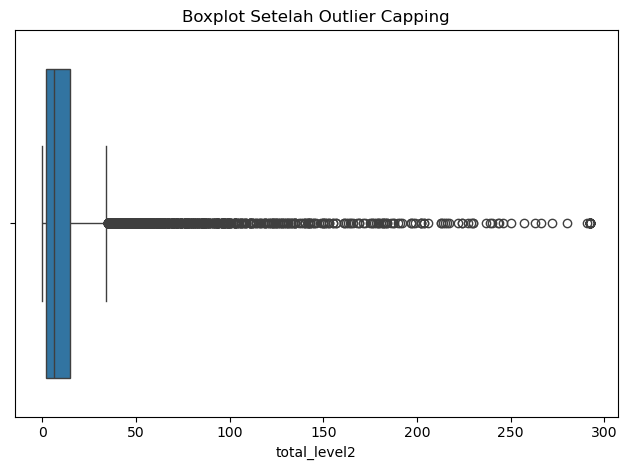

Batas atas untuk 'total_dc_fast' adalah: 54.00

Distribusi SETELAH capping:


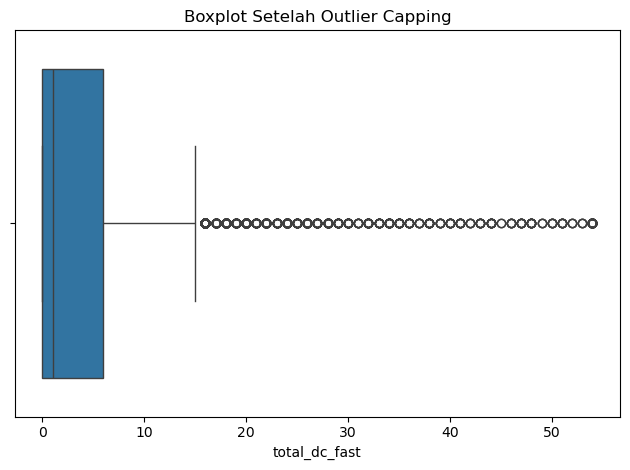

Batas atas untuk 'avg_station_age_days' adalah: 2846787.23

Distribusi SETELAH capping:


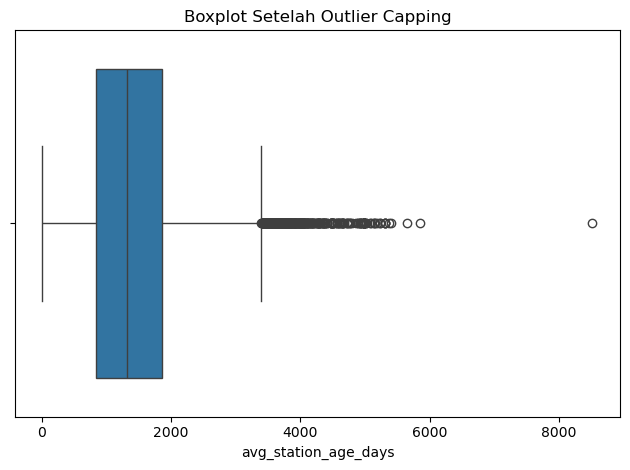

Batas atas untuk 'last_station_opened_days_ago' adalah: 1544796.00

Distribusi SETELAH capping:


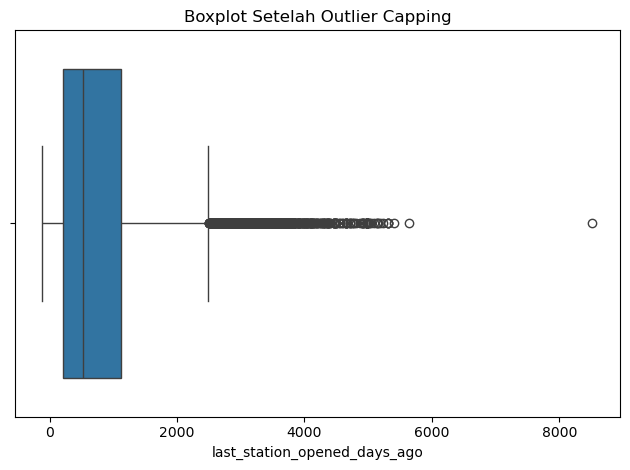

Batas atas untuk 'new_station_last_2_years' adalah: 6.00

Distribusi SETELAH capping:


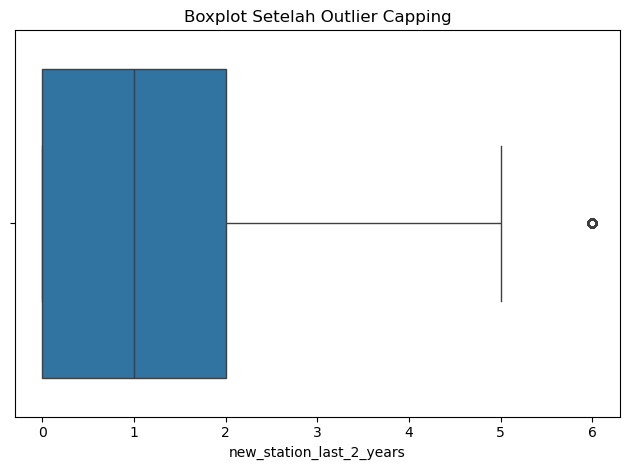

In [40]:
features_to_cap = 'EV DC Fast Count'

for col in numeric_features:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 * 1.5 * IQR

    print(f"Batas atas untuk '{col}' adalah: {upper_bound:.2f}")

    X_train_capped = X_train.copy()
    X_test_capped = X_test.copy()

    X_train_capped[col] = X_train_capped[col].clip(upper=upper_bound)
    X_test_capped[col] = X_test_capped[col].clip(upper=upper_bound)

    print("\nDistribusi SETELAH capping:")
    sns.boxplot(x=X_train_capped[col])
    plt.title('Boxplot Setelah Outlier Capping')
    plt.tight_layout()
    plt.show()

In [194]:
print("Memulai training model pipeline (capping method - random forest)...")
model_pipeline_rf.fit(X_train_capped, y_train)
print("Training selesai!")

print("\nMemulai training model pipeline (capping method - decision tree)...")
model_pipeline_dt.fit(X_train_capped, y_train)
print("Training selesai!")

print("\nMemulai training model pipeline (capping method - linear regression)...")
model_pipeline_linreg.fit(X_train_capped, y_train)
print("Training selesai!")

print("\nMemulai training model pipeline (capping method - lasso)...")
model_pipeline_lasso.fit(X_train_capped, y_train)
print("Training selesai!")

Memulai training model pipeline (capping method - random forest)...
Training selesai!

Memulai training model pipeline (capping method - decision tree)...
Training selesai!

Memulai training model pipeline (capping method - linear regression)...
Training selesai!

Memulai training model pipeline (capping method - lasso)...
Training selesai!


In [195]:
y_pred_rf = model_pipeline_rf.predict(X_test_capped)
y_pred_dt = model_pipeline_dt.predict(X_test_capped)
y_pred_linreg = model_pipeline_linreg.predict(X_test_capped)
y_pred_lasso = model_pipeline_linreg.predict(X_test_capped)

r2_rf = r2_score(y_test, y_pred_rf)
r2_dt = r2_score(y_test, y_pred_dt)
r2_linreg = r2_score(y_test, y_pred_linreg)
r2_lasso = r2_score(y_test, y_pred_lasso)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("Hasil Evaluasi Model (capping method - random forest):")
print(f"R-squared (R2) : {r2_rf:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_rf:.4f}")

print("\nHasil Evaluasi Model (capping method - decision tree):")
print(f"R-squared (R2) (capping method) : {r2_dt:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_dt:.4f}")

print("\nHasil Evaluasi Model (capping method - linear regression):")
print(f"R-squared (R2) : {r2_linreg:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_linreg:.4f}")

print("\nHasil Evaluasi Model (capping method - lasso):")
print(f"R-squared (R2) : {r2_lasso:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_lasso:.4f}")


Hasil Evaluasi Model (capping method - random forest):
R-squared (R2) : 0.7945
Root Mean Squared Error (RMSE) : 5.6984

Hasil Evaluasi Model (capping method - decision tree):
R-squared (R2) (capping method) : 0.7872
Root Mean Squared Error (RMSE) : 5.7994

Hasil Evaluasi Model (capping method - linear regression):
R-squared (R2) : 0.8337
Root Mean Squared Error (RMSE) : 5.1266

Hasil Evaluasi Model (capping method - lasso):
R-squared (R2) : 0.8337
Root Mean Squared Error (RMSE) : 5.1266


In [196]:
numeric_transformer_discrete = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')), 
    ('scaler', StandardScaler())
])

preprocessor_discrete = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_discrete, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ], verbose_feature_names_out=False, n_jobs=-1, remainder='passthrough')

model_pipeline_discrete_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_discrete),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model_pipeline_discrete_dt = Pipeline(steps=[
    ('preprocessor', preprocessor_discrete),
    ('regressor', DecisionTreeRegressor())
])

model_pipeline_discrete_linreg = Pipeline(steps=[
    ('preprocessor', preprocessor_discrete),
    ('regressor', LinearRegression())
])

model_pipeline_discrete_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor_discrete),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

In [197]:
print("Memulai training model pipeline dengan diskritisasi (random forest)...")
model_pipeline_discrete_rf.fit(X_train, y_train) 
print("Training selesai!")

print("\nMemulai training model pipeline dengan diskritisasi (decision tree)...")
model_pipeline_discrete_dt.fit(X_train, y_train) 
print("Training selesai!")

print("\nMemulai training model pipeline dengan diskritisasi (linear regression)...")
model_pipeline_discrete_linreg.fit(X_train, y_train) 
print("Training selesai!")

print("\nMemulai training model pipeline dengan diskritisasi (lasso)...")
model_pipeline_discrete_lasso.fit(X_train, y_train) 
print("Training selesai!")

Memulai training model pipeline dengan diskritisasi (random forest)...
Training selesai!

Memulai training model pipeline dengan diskritisasi (decision tree)...
Training selesai!

Memulai training model pipeline dengan diskritisasi (linear regression)...
Training selesai!

Memulai training model pipeline dengan diskritisasi (lasso)...
Training selesai!


In [198]:
y_pred_discrete_rf = model_pipeline_discrete_rf.predict(X_test)
y_pred_discrete_dt = model_pipeline_discrete_dt.predict(X_test)
y_pred_discrete_linreg = model_pipeline_discrete_linreg.predict(X_test)
y_pred_discrete_lasso = model_pipeline_discrete_lasso.predict(X_test)

r2_discrete_rf = r2_score(y_test, y_pred_discrete_rf)
r2_discrete_dt = r2_score(y_test, y_pred_discrete_dt)
r2_discrete_linreg = r2_score(y_test, y_pred_discrete_linreg)
r2_discrete_lasso = r2_score(y_test, y_pred_discrete_lasso)

rmse_discrete_rf = np.sqrt(mean_squared_error(y_test, y_pred_discrete_rf))
rmse_discrete_dt = np.sqrt(mean_squared_error(y_test, y_pred_discrete_dt))
rmse_discrete_linreg = np.sqrt(mean_squared_error(y_test, y_pred_discrete_linreg))
rmse_discrete_lasso = np.sqrt(mean_squared_error(y_test, y_pred_discrete_lasso))

print("Hasil Evaluasi Model (Diskritisasi - random forest):")
print(f"R-squared (R2) : {r2_discrete_rf:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_discrete_rf:.4f}")

print("\nHasil Evaluasi Model (Diskritisasi - decision tree):")
print(f"R-squared (R2) (capping method) : {r2_discrete_dt:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_discrete_dt:.4f}")

print("\nHasil Evaluasi Model (Diskritisasi - linear regression):")
print(f"R-squared (R2) : {r2_discrete_linreg:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_discrete_linreg:.4f}")

print("\nHasil Evaluasi Model (Diskritisasi - lasso):")
print(f"R-squared (R2) : {r2_discrete_lasso:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_discrete_lasso:.4f}")

Hasil Evaluasi Model (Diskritisasi - random forest):
R-squared (R2) : 0.4665
Root Mean Squared Error (RMSE) : 9.1825

Hasil Evaluasi Model (Diskritisasi - decision tree):
R-squared (R2) (capping method) : 0.4274
Root Mean Squared Error (RMSE) : 9.5128

Hasil Evaluasi Model (Diskritisasi - linear regression):
R-squared (R2) : 0.3349
Root Mean Squared Error (RMSE) : 10.2525

Hasil Evaluasi Model (Diskritisasi - lasso):
R-squared (R2) : 0.3122
Root Mean Squared Error (RMSE) : 10.4262


In [46]:
from sklearn.linear_model import Lasso

In [182]:
model_pipeline_lasso

,steps,"[('preprocessor', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [200]:
lasso_model = model_pipeline_lasso['regressor']
feature_names = model_pipeline_lasso['preprocessor'].get_feature_names_out()

print(f"Jumlah fitur yang digunakan oleh Lasso: {np.sum(lasso_model.coef_ != 0)}")
df_coef = pd.DataFrame({'feature': feature_names, 'coefficient': lasso_model.coef_})
print(df_coef[df_coef['coefficient'] != 0])

Jumlah fitur yang digunakan oleh Lasso: 3
                    feature  coefficient
0              total_level2     8.549879
1             total_dc_fast     0.379394
4  new_station_last_2_years     1.676741


In [49]:
from sklearn.model_selection import KFold, cross_val_score

In [50]:
pipelines = {
    'Linear Regression': Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('selection_variance', VarianceThreshold(threshold=0.01)),
            ('selection_duplicate', DropDuplicateFeatures()),
            ('linreg', LinearRegression())
        ]),
    'Lasso': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('lasso', Lasso(alpha=1.0, random_state=42))
        ]),
    # 'Random Forest': Pipeline(steps=[
    #         ('preprocessor', preprocessor),
    #         ('selection_variance', VarianceThreshold(threshold=0.01)),
    #         ('selection_duplicate', DropDuplicateFeatures()),
    #         ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    #     ]), # Pipeline RF Anda yang sudah ada
    'LightGBM': Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('selection_variance', VarianceThreshold(threshold=0.01)),
            ('selection_duplicate', DropDuplicateFeatures()),
            ('lgbm', LGBMRegressor(force_col_wise=True, verbose = -1, random_state=0))
        ]),
    'Decision Tree':Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('selection_variance', VarianceThreshold(threshold=0.01)),
            ('selection_duplicate', DropDuplicateFeatures()),
            ('dt', DecisionTreeRegressor(random_state=0))
        ]),
    'Gradient Boosting': Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('selection_variance', VarianceThreshold(threshold=0.01)),
            ('selection_duplicate', DropDuplicateFeatures()),
            ('gb', GradientBoostingRegressor(loss='huber',criterion='squared_error',random_state=0))
        ]),
    'XG Boost': Pipeline(steps=[
            ('preprocessor', preprocessor), 
            ('selection_variance', VarianceThreshold(threshold=0.01)),
            ('selection_duplicate', DropDuplicateFeatures()),
            ('xgb', XGBRegressor())
        ]),
        
}


In [51]:
model_names = []
mean_mae_cv = []
std_mae_cv = []
mean_r2_cv = []
std_r2_cv = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
print("="*70)
print("Memulai Tanpa Cross-Validation untuk semua model...")
print("="*70)

Memulai Tanpa Cross-Validation untuk semua model...


In [53]:
results = {}
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1)
    results[name] = -scores
    print(f"{name} -> Rata-rata RMSE: {results[name].mean():.4f} (Std: {results[name].std():.4f})")

Linear Regression -> Rata-rata RMSE: 4.7811 (Std: 0.6725)
Lasso -> Rata-rata RMSE: 5.1592 (Std: 0.6382)
LightGBM -> Rata-rata RMSE: 4.6548 (Std: 1.0202)
Decision Tree -> Rata-rata RMSE: 6.0588 (Std: 0.9840)
Gradient Boosting -> Rata-rata RMSE: 4.2450 (Std: 0.7338)
XG Boost -> Rata-rata RMSE: 4.4002 (Std: 0.8033)


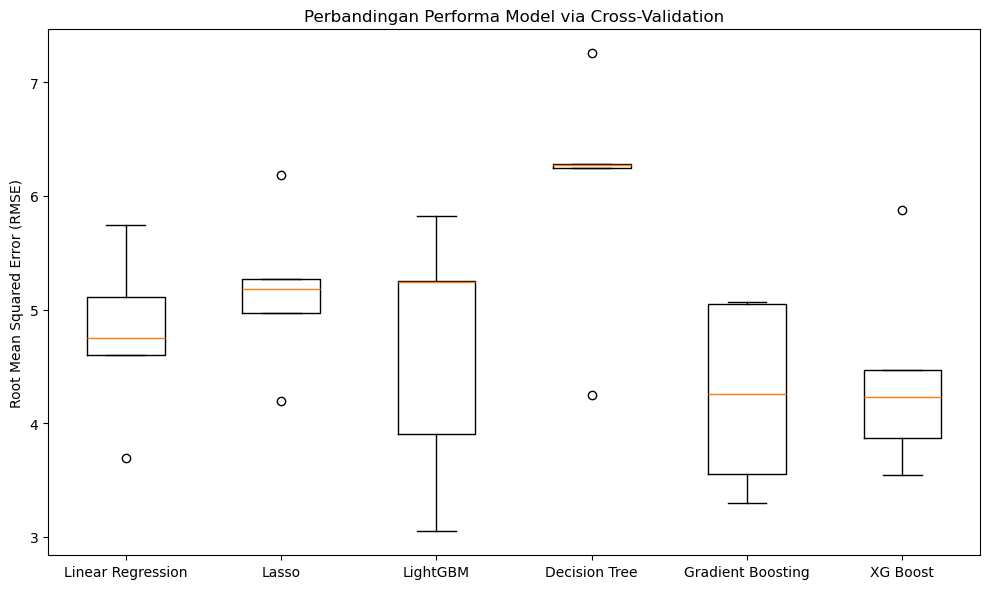

In [54]:
plt.figure(figsize=(10, 6))
plt.boxplot(results.values(), labels=results.keys())
plt.title('Perbandingan Performa Model via Cross-Validation')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.tight_layout()
plt.show()

In [55]:
print("="*70)
print("Memulai Cross-Validation untuk semua model...")
print("="*70)

Memulai Cross-Validation untuk semua model...


In [56]:
for name, pipeline in pipelines.items():
    
    cv_mae = -cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_r2 = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)
    
    model_names.append(name)
    mean_mae_cv.append(cv_mae.mean())
    std_mae_cv.append(cv_mae.std())
    mean_r2_cv.append(cv_r2.mean())
    std_r2_cv.append(cv_r2.std())
    
    print(f"Selesai untuk model: {name}")

Selesai untuk model: Linear Regression
Selesai untuk model: Lasso
Selesai untuk model: LightGBM
Selesai untuk model: Decision Tree
Selesai untuk model: Gradient Boosting
Selesai untuk model: XG Boost


In [57]:
print("="*70)
print("\nCross-Validation Selesai!")
print("="*70)


Cross-Validation Selesai!


In [58]:
hasil_cv_df = pd.DataFrame({
    'Model': model_names,
    'Mean R2': mean_r2_cv,
    'Std R2': std_r2_cv,
    'Mean MAE': mean_mae_cv,
    'Std MAE': std_mae_cv
})

In [59]:
hasil_cv_df = hasil_cv_df.sort_values(by='Mean R2', ascending=False).reset_index(drop=True)

print("\nHasil Perbandingan Model dari Cross-Validation:")
print(hasil_cv_df)


Hasil Perbandingan Model dari Cross-Validation:
               Model   Mean R2    Std R2  Mean MAE   Std MAE
0  Gradient Boosting  0.863182  0.029780  1.463992  0.073335
1           XG Boost  0.863032  0.033233  1.422910  0.073400
2           LightGBM  0.849068  0.037779  1.444925  0.051794
3  Linear Regression  0.827543  0.064024  1.941748  0.067976
4              Lasso  0.804257  0.049355  2.277084  0.058691
5      Decision Tree  0.750277  0.084803  1.824011  0.077824


In [60]:
print("="*70)
print("Memulai Hyperparameter Tunning untuk semua model...")
print("="*70)

Memulai Hyperparameter Tunning untuk semua model...


In [61]:
pipelines_to_tune = {
    'Gradient Boosting': pipelines['Gradient Boosting'],
    'LightGBM': pipelines['LightGBM'],
    # 'Random Forest': pipelines['Random Forest'],
    'Linear Regression': pipelines['Linear Regression'],
    'XG Boost': pipelines['XG Boost'],
    'Lasso': pipelines['Lasso'],
    'Decision Tree': pipelines['Decision Tree']
}


In [62]:
param_grids = {
    'Linear Regression': {},
    'Lasso': {
        'lasso__alpha': np.arange(0.01, 1.0, 0.01)
    },
    'Decision Tree': {
        'dt__splitter': ['best','random'],
        'dt__max_depth': np.arange(1,10), 
        'dt__min_samples_split': np.arange(2,10),
        'dt__min_samples_leaf': np.arange(1,5)
    },
    'Gradient Boosting': {
        'gb__n_estimators': [200, 250, 350],
        'gb__learning_rate': [0.75, 0.1, 1.25],
        'gb__max_depth': [3, 5],
        'gb__min_samples_split': [5, 6, 7, 8],
        'gb__min_samples_leaf':[1, 2, 3]
    },
    'LightGBM': {
        'lgbm__n_estimators': [200, 300, 400],
        'lgbm__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'lgbm__num_leaves': [20, 31]
    },
    'XG Boost': {
        'xgb__learning_rate':[0.01, 0.05, 0.1],
        'xgb__n_estimators':[200, 300, 400]
    },
    # 'Random Forest': {
    #     'rf__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    #     'rf__n_estimators': [100, 200],
    #     'rf__min_samples_split': np.arange(2,10),
    #     'rf__max_depth': [10, 20],
    #     'rf__min_samples_leaf': np.arange(1,5)
    # }
}

In [63]:
tuning_results = []

In [64]:
print("\n" + "="*70)
print("Memulai Hyperparameter Tuning untuk Model Teratas...")
print("="*70)


Memulai Hyperparameter Tuning untuk Model Teratas...


In [65]:
# for name, pipeline in pipelines_to_tune.items():
#     print(f"--> Tuning untuk model: {name}")
    
#     grid_param = param_grids[name]
    
#     grid_search = GridSearchCV(estimator=pipeline,
#                                param_grid=grid_param,
#                                cv=kf,
#                                scoring='neg_mean_absolute_error',
#                                n_jobs=-1,
#                                verbose=1)
    
#     grid_search.fit(X_train, y_train)
    
#     tuning_results.append({
#         'Model': name,
#         'Best Params': grid_search.best_params_,
#         'Best CV RMSE': -grid_search.best_score_
#     })
    
#     print(f"Tuning untuk {name} selesai.\n")

# tuning_results_df = pd.DataFrame(tuning_results)

# print('\n','='*70)
# print('Hasil Hyperparameter Tunning:')
# print('='*70)
# print(tuning_results_df)

In [66]:
# best_model_name = tuning_results_df.iloc[0]['Model']

# best_model_info = tuning_results_df.iloc[0]
# best_model_name = best_model_info['Model']
# best_params = best_model_info['Best Params']

In [96]:
best_model_name = 'Gradient Boosting'

best_params = {
    'gb__learning_rate': 0.1,
    'gb__max_depth': 5,
    'gb__min_samples_leaf': 2,
    'gb__min_samples_split': 5,
    'gb__n_estimators': 400
}

In [97]:
print("\n" + "="*70)
print(f"Model terbaik berdasarkan Hyperparameter Tunning adalah: {best_model_name}")
print(f"Dengan parameter terbaik: {best_params}")
print("="*70)


Model terbaik berdasarkan Hyperparameter Tunning adalah: Gradient Boosting
Dengan parameter terbaik: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_samples_leaf': 2, 'gb__min_samples_split': 5, 'gb__n_estimators': 400}


In [98]:
full_experimental_pipeline = pipelines[best_model_name]
full_experimental_pipeline.set_params(**best_params)

print("\nMelatih ulang model terbaik pada seluruh data training...")
full_experimental_pipeline.fit(X_train, y_train)


Melatih ulang model terbaik pada seluruh data training...


,steps,"[('preprocessor', ...), ('selection_variance', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [99]:
processed_feature_names = full_experimental_pipeline['preprocessor'].get_feature_names_out()
variance_mask = full_experimental_pipeline['selection_variance'].get_support()
features_after_variance = processed_feature_names[variance_mask]
features_to_drop_duplicated = full_experimental_pipeline['selection_duplicate'].features_to_drop_
final_selected_features = [col for col in features_after_variance if col not in features_to_drop_duplicated]
print(f'ada {len(final_selected_features)} feature final yang dipakai untuk deployment')

ada 49 feature final yang dipakai untuk deployment


In [100]:
final_selected_features

['total_level2',
 'total_dc_fast',
 'avg_station_age_days',
 'last_station_opened_days_ago',
 'new_station_last_2_years',
 'dominant_facility_type_BREWERY_DISTILLERY_WINERY',
 'dominant_facility_type_CAR_DEALER',
 'dominant_facility_type_COLLEGE_CAMPUS',
 'dominant_facility_type_CONVENIENCE_STORE',
 'dominant_facility_type_FED_GOV',
 'dominant_facility_type_GAS_STATION',
 'dominant_facility_type_GROCERY',
 'dominant_facility_type_HOTEL',
 'dominant_facility_type_INN',
 'dominant_facility_type_MULTI_UNIT_DWELLING',
 'dominant_facility_type_MUNI_GOV',
 'dominant_facility_type_OFFICE_BLDG',
 'dominant_facility_type_OTHER',
 'dominant_facility_type_PARK',
 'dominant_facility_type_PARKING_LOT',
 'dominant_facility_type_PUBLIC',
 'dominant_facility_type_RESTAURANT',
 'dominant_facility_type_SHOPPING_CENTER',
 'dominant_facility_type_UTILITY',
 'dominant_facility_type_None',
 'dominant_ev_network_AMPUP',
 'dominant_ev_network_Blink Network',
 'dominant_ev_network_ChargePoint Network',
 'domin

In [101]:
print("Pelatihan ulang selesai!")

Pelatihan ulang selesai!


In [102]:
final_preprocessor = ColumnTransformer([
    ('selector', 'passthrough', final_selected_features)
], remainder='drop', verbose_feature_names_out=False, n_jobs=-1)

In [103]:
best_params_cleaned = {key.split('__')[1]: value for key, value in best_params.items()}
final_regressor = GradientBoostingRegressor(**best_params_cleaned, random_state=0)

In [104]:
deployment_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('final_selection', final_preprocessor),
    ('gb', final_regressor)
])

print("\nMelatih pipeline final untuk deployment...")
deployment_pipeline.fit(X_train, y_train)
print('Training model selesai!')


Melatih pipeline final untuk deployment...
Training model selesai!


In [105]:
final_predictions = deployment_pipeline.predict(X_test)

final_r2 = r2_score(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

In [106]:
print(f"\n--- HASIL FINAL MODEL TERBAIK ({best_model_name}) ---")
print(f"R-squared (R2) di Test Set: {final_r2:.4f}")
print(f"Root Mean Squared Error (RMSE) di Test Set: {final_rmse:.4f}")


--- HASIL FINAL MODEL TERBAIK (Gradient Boosting) ---
R-squared (R2) di Test Set: 0.9169
Root Mean Squared Error (RMSE) di Test Set: 3.6238


In [108]:
joblib.dump(deployment_pipeline, f'best_model_{best_model_name.replace(" ", "_")}.pkl')
print(f"\nModel terbaik telah disimpan ke file 'best_model_{best_model_name.replace(' ', '_')}.pkl'")


Model terbaik telah disimpan ke file 'best_model_Gradient_Boosting.pkl'


In [109]:
final_model_best_pipe = deployment_pipeline['gb']
final_feature_names = final_model_best_pipe.feature_names_in_
final_importances = final_model_best_pipe.feature_importances_

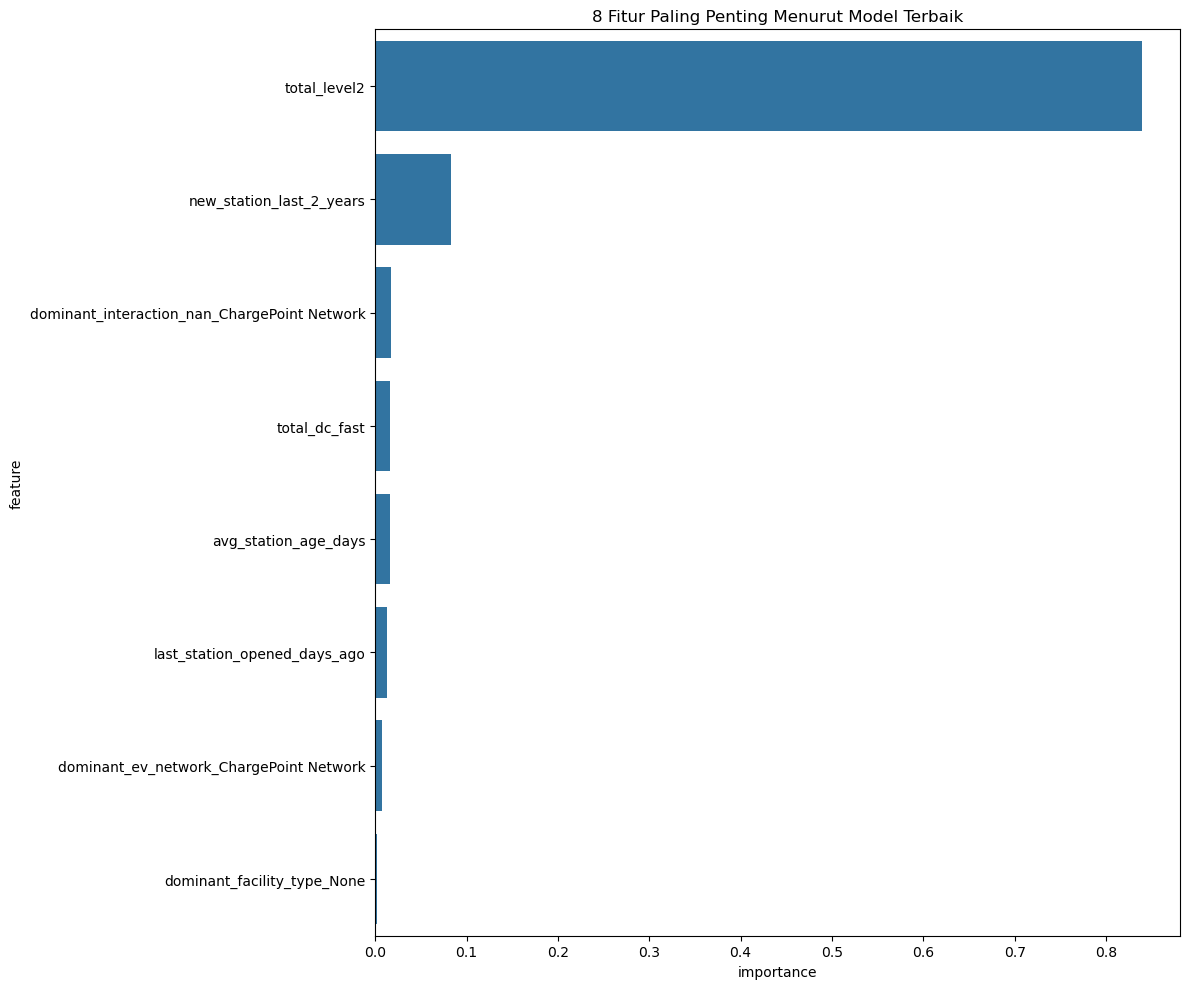

In [110]:
df_importance = pd.DataFrame({
    'feature': final_feature_names,
    'importance': final_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=df_importance.head(8))
plt.title('8 Fitur Paling Penting Menurut Model Terbaik')
plt.tight_layout()
plt.show()

In [111]:
print("Fitur Teratas:")
print(df_importance.head(8))

Fitur Teratas:
                                         feature  importance
0                                   total_level2    0.838913
4                       new_station_last_2_years    0.082987
44  dominant_interaction_nan_ChargePoint Network    0.017604
1                                  total_dc_fast    0.016189
2                           avg_station_age_days    0.015741
3                   last_station_opened_days_ago    0.012553
27       dominant_ev_network_ChargePoint Network    0.007053
24                   dominant_facility_type_None    0.002465


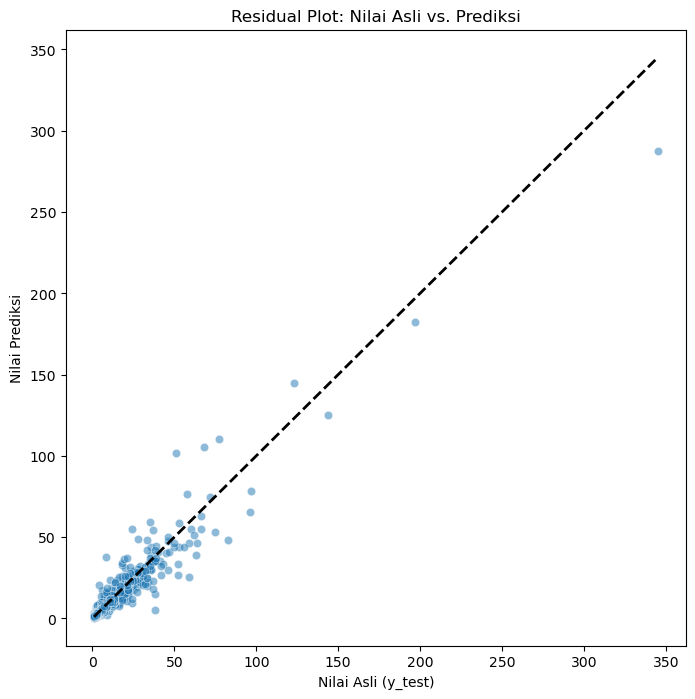

In [112]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=final_predictions, alpha=0.5)
plt.xlabel('Nilai Asli (y_test)')
plt.ylabel('Nilai Prediksi')
plt.title('Residual Plot: Nilai Asli vs. Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

In [116]:
print("\n" + "="*70)
print("Mempersiapkan data untuk analisis SHAP...")
print("="*70)


Mempersiapkan data untuk analisis SHAP...


In [117]:
data_transformer_pipeline = Pipeline([
    ('preprocessor', deployment_pipeline['preprocessor']),
    ('feature_selection', deployment_pipeline['final_selection'])
])


In [118]:
X_train_transformed = data_transformer_pipeline.transform(X_train)
df_X_train_transformed = pd.DataFrame(X_train_transformed, columns=final_feature_names)

In [119]:
df_X_train_transformed

,total_level2,total_dc_fast,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years,dominant_facility_type_BREWERY_DISTILLERY_WINERY,dominant_facility_type_CAR_DEALER,dominant_facility_type_COLLEGE_CAMPUS,dominant_facility_type_CONVENIENCE_STORE,dominant_facility_type_FED_GOV,dominant_facility_type_GAS_STATION,dominant_facility_type_GROCERY,dominant_facility_type_HOTEL,dominant_facility_type_INN,dominant_facility_type_MULTI_UNIT_DWELLING,dominant_facility_type_MUNI_GOV,dominant_facility_type_OFFICE_BLDG,dominant_facility_type_OTHER,dominant_facility_type_PARK,dominant_facility_type_PARKING_LOT,dominant_facility_type_PUBLIC,dominant_facility_type_RESTAURANT,dominant_facility_type_SHOPPING_CENTER,dominant_facility_type_UTILITY,dominant_facility_type_None,dominant_ev_network_AMPUP,dominant_ev_network_Blink Network,dominant_ev_network_ChargePoint Network,dominant_ev_network_EV Connect,dominant_ev_network_Electrify America,dominant_ev_network_FLO,dominant_ev_network_Non-Networked,dominant_ev_network_RED_E,dominant_ev_network_SHELL_RECHARGE,dominant_ev_network_Tesla,dominant_ev_network_Tesla Destination,dominant_interaction_CAR_DEALER_Non-Networked,dominant_interaction_FED_GOV_Non-Networked,dominant_interaction_GAS_STATION_Tesla,dominant_interaction_HOTEL_Non-Networked,dominant_interaction_HOTEL_Tesla Destination,dominant_interaction_PARKING_LOT_Non-Networked,dominant_interaction_PUBLIC_RED_E,dominant_interaction_nan_Blink Network,dominant_interaction_nan_ChargePoint Network,dominant_interaction_nan_EV Connect,dominant_interaction_nan_FLO,dominant_interaction_nan_SHELL_RECHARGE,dominant_interaction_nan_Tesla Destination
0,-0.314601,-0.531297,2.189921,2.766448,-0.479999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.425543,0.091542,-1.487462,-0.769851,-0.253986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.018226,-0.531297,-0.548290,-0.436485,0.198038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.370072,-0.531297,-1.132865,-0.428859,-0.253986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.295581,0.091542,-0.359178,-0.721916,1.780124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9771,-0.259130,-0.531297,-0.822829,-0.828681,-0.253986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9772,-0.286865,-0.531297,-0.503541,-0.597721,-0.027974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9773,-0.064981,-0.323684,0.691476,-0.331899,-0.027974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9774,-0.370072,-0.531297,-1.077353,-0.375477,-0.253986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
print('menghitung nilai SHAP...')

menghitung nilai SHAP...


In [120]:
explainer = shap.TreeExplainer(final_regressor)
shap_values = explainer.shap_values(df_X_train_transformed)

In [122]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


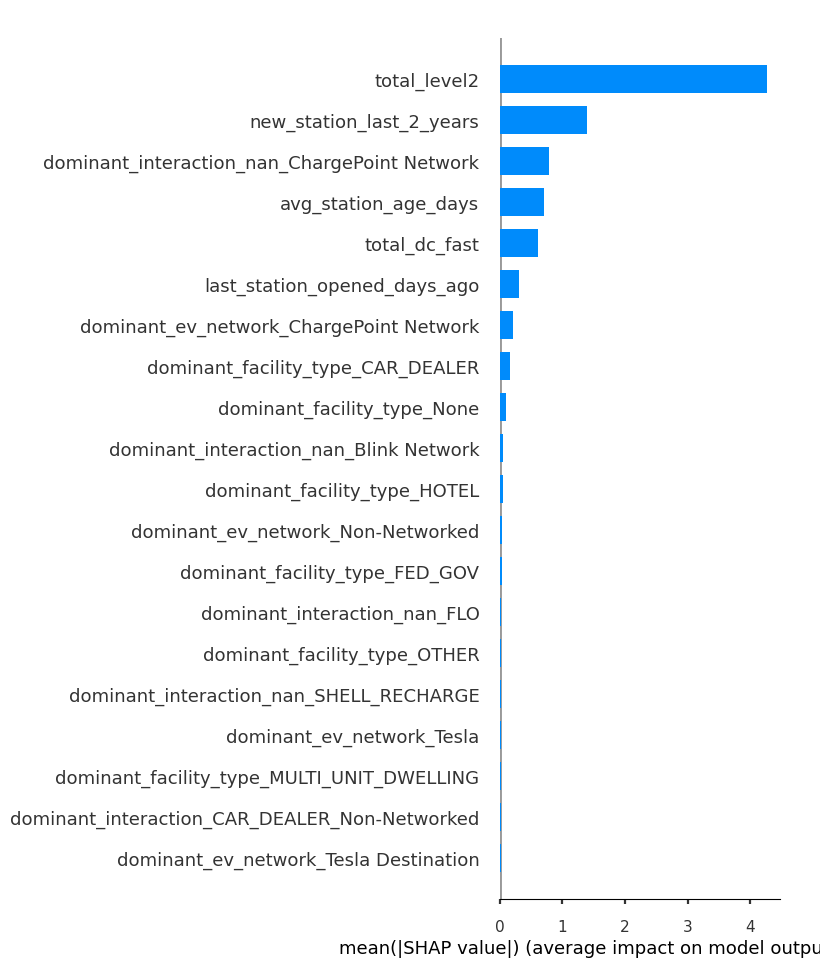

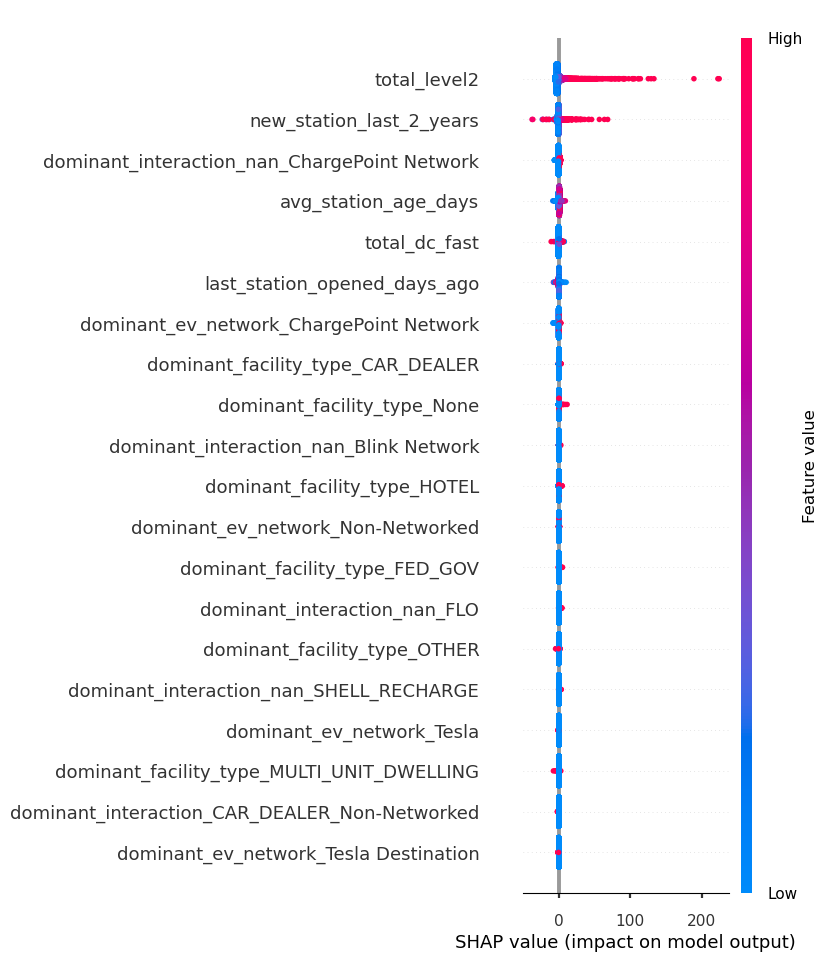

In [123]:
with plt.style.context('seaborn-v0_8-poster'):
    shap.summary_plot(shap_values, df_X_train_transformed, feature_names=final_feature_names, plot_type="bar", show=False)
    plt.title("SHAP Summary Plot (Bar)", color="white")
    plt.show()

    shap.summary_plot(shap_values, df_X_train_transformed, feature_names=final_feature_names, show=False)
    plt.title("SHAP Summary Plot (Dot)", color="white")
    plt.show()

In [124]:
from sklearn.tree import export_text

one_tree = final_model_best_pipe.estimators_[0][0]
rules_tree = export_text(one_tree, feature_names=list(final_feature_names))
print("--- CONTOH ATURAN DARI 1 DARI 350 POHON KEPUTUSAN ---")
print(rules_tree)

--- CONTOH ATURAN DARI 1 DARI 350 POHON KEPUTUSAN ---
|--- total_level2 <= 1.67
|   |--- total_level2 <= 0.09
|   |   |--- total_level2 <= -0.25
|   |   |   |--- new_station_last_2_years <= -0.14
|   |   |   |   |--- total_level2 <= -0.36
|   |   |   |   |   |--- value: [-5.37]
|   |   |   |   |--- total_level2 >  -0.36
|   |   |   |   |   |--- value: [-4.32]
|   |   |   |--- new_station_last_2_years >  -0.14
|   |   |   |   |--- new_station_last_2_years <= 0.31
|   |   |   |   |   |--- value: [-3.45]
|   |   |   |   |--- new_station_last_2_years >  0.31
|   |   |   |   |   |--- value: [-0.30]
|   |   |--- total_level2 >  -0.25
|   |   |   |--- total_dc_fast <= -0.27
|   |   |   |   |--- dominant_interaction_nan_ChargePoint Network <= 0.50
|   |   |   |   |   |--- value: [-3.10]
|   |   |   |   |--- dominant_interaction_nan_ChargePoint Network >  0.50
|   |   |   |   |   |--- value: [-0.84]
|   |   |   |--- total_dc_fast >  -0.27
|   |   |   |   |--- new_station_last_2_years <= 0.76
| 

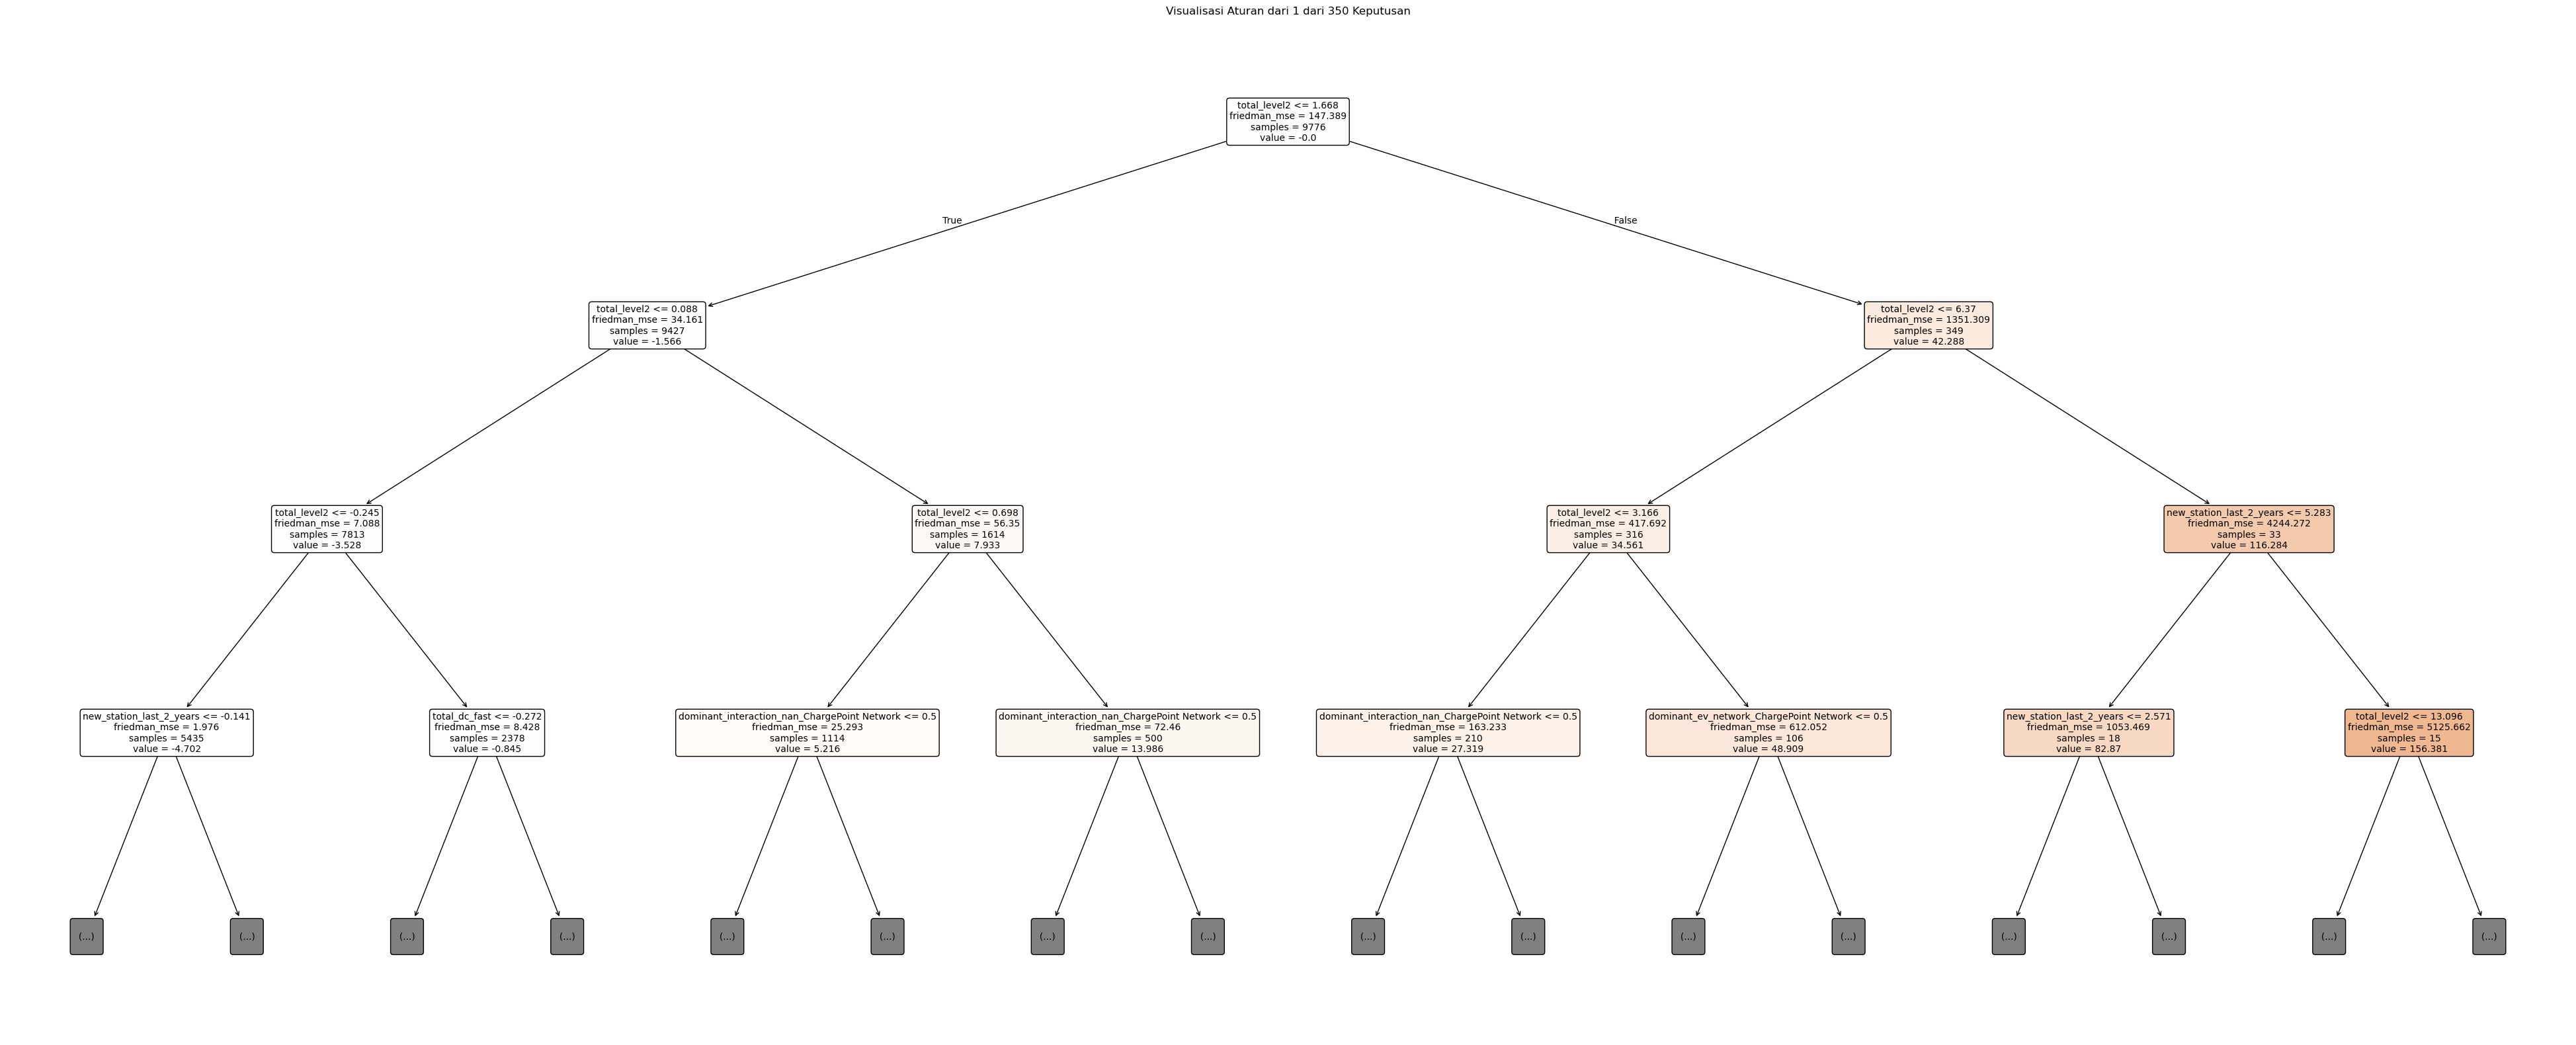

In [125]:
plt.figure(figsize=(50,20))

plot_tree(one_tree, 
          feature_names=list(final_feature_names), 
          filled=True, 
          rounded=True, 
          max_depth=3, 
          fontsize=10)


plt.title('Visualisasi Aturan dari 1 dari 350 Keputusan')
plt.show()

## OPTIMIZATION

In [202]:
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from geopy.distance import geodesic

In [127]:
print(df_ev.columns)
print('\ntotal data EV Level2 EVSE Num =',len(df_ev['EV Level2 EVSE Num']))
print('(mean) missing data EV Level2 EVSE Num =',round(df_ev['EV Level2 EVSE Num'].isna().mean() * 100, 2),'%')
print('\ntotal data EV DC Fast Count =',len(df_ev['EV DC Fast Count']))
print('(mean) missing data EV DC Fast Count =',round(df_ev['EV DC Fast Count'].isna().mean() * 100, 2),'%')

Index(['Fuel Type Code', 'City', 'State', 'ZIP', 'Status Code',
       'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count',
       'EV Network', 'Latitude', 'Longitude', 'Owner Type Code', 'Open Date',
       'EV Connector Types', 'Country', 'Access Code', 'Facility Type',
       'EV Pricing', 'EV On-Site Renewable Source', 'Restricted Access',
       'Maximum Vehicle Class', 'EV Workplace Charging', 'Funding Sources',
       'station_age_days', 'facility_network_interaction'],
      dtype='object')

total data EV Level2 EVSE Num = 81370
(mean) missing data EV Level2 EVSE Num = 15.45 %

total data EV DC Fast Count = 81370
(mean) missing data EV DC Fast Count = 83.02 %


In [128]:
df_ev['EV Level2 EVSE Num'] = pd.to_numeric(df_ev['EV Level2 EVSE Num'], errors='coerce').fillna(0)
df_ev['EV DC Fast Count'] = pd.to_numeric(df['EV DC Fast Count'], errors='coerce').fillna(0)
df_ev['Latitude'] = pd.to_numeric(df_ev['Latitude'], errors='coerce')
df_ev['Longitude'] = pd.to_numeric(df_ev['Longitude'], errors='coerce')
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81370 entries, 123 to 112831
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Fuel Type Code                81370 non-null  object        
 1   City                          81367 non-null  object        
 2   State                         81370 non-null  object        
 3   ZIP                           81368 non-null  object        
 4   Status Code                   81370 non-null  object        
 5   EV Level1 EVSE Num            593 non-null    float64       
 6   EV Level2 EVSE Num            81370 non-null  float64       
 7   EV DC Fast Count              81370 non-null  float64       
 8   EV Network                    81369 non-null  object        
 9   Latitude                      81370 non-null  float64       
 10  Longitude                     81370 non-null  float64       
 11  Owner Type Code               

In [129]:
df_ev.dropna(subset=['ZIP', 'Latitude', 'Longitude'], inplace=True)
df_ev

,Fuel Type Code,City,State,ZIP,Status Code,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV Network,Latitude,Longitude,Owner Type Code,Open Date,EV Connector Types,Country,Access Code,Facility Type,EV Pricing,EV On-Site Renewable Source,Restricted Access,Maximum Vehicle Class,EV Workplace Charging,Funding Sources,station_age_days,facility_network_interaction
123,ELEC,Sun Valley,CA,91352,E,NaN,57.0,2.0,Non-Networked,34.248319,-118.387971,LG,1999-10-15,CHADEMO J1772 J1772COMBO,US,private,UTILITY,NaN,NaN,NaN,NaN,True,NaN,9477.0,UTILITY_Non-Networked
124,ELEC,Los Angeles,CA,90015,E,NaN,7.0,0.0,Non-Networked,34.040539,-118.271387,P,1995-08-30,J1772,US,public,PARKING_GARAGE,Free; parking fee,NaN,False,LD,False,NaN,10984.0,PARKING_GARAGE_Non-Networked
125,ELEC,Los Angeles,CA,90012,E,NaN,338.0,12.0,Non-Networked,34.059133,-118.248589,LG,1999-10-15,CHADEMO J1772 J1772COMBO,US,private,UTILITY,NaN,NaN,NaN,LD,True,NaN,9477.0,UTILITY_Non-Networked
126,ELEC,Long Beach,CA,90803,E,NaN,19.0,1.0,Non-Networked,33.759802,-118.096665,LG,2018-05-01,CHADEMO J1772 J1772COMBO,US,private,UTILITY,NaN,NaN,NaN,NaN,True,NaN,2704.0,UTILITY_Non-Networked
127,ELEC,Wilmington,CA,90744,E,NaN,10.0,0.0,Non-Networked,33.770508,-118.265628,LG,1999-10-15,J1772,US,private,UTILITY,NaN,NaN,NaN,NaN,True,NaN,9477.0,UTILITY_Non-Networked
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112822,ELEC,Beaver,UT,84713,E,NaN,0.0,8.0,IONNA,38.292689,-112.646501,NaN,2025-09-18,J1772COMBO TESLA,US,public,NaN,NaN,NaN,False,NaN,False,NaN,7.0,nan_IONNA
112823,ELEC,Teaticket,MA,02536,E,NaN,0.0,4.0,RED_E,41.577910,-70.577920,NaN,2025-09-17,J1772COMBO,US,public,PUBLIC,NaN,NaN,False,NaN,False,NaN,8.0,PUBLIC_RED_E
112824,ELEC,Bristol,CT,06010,E,NaN,0.0,4.0,RED_E,41.682196,-72.951026,NaN,2025-09-17,J1772COMBO,US,public,PUBLIC,NaN,NaN,False,NaN,False,NaN,8.0,PUBLIC_RED_E
112826,ELEC,Jamaica Plain,MA,02130,E,NaN,10.0,0.0,AMPUP,42.322760,-71.111050,P,2025-05-23,J1772,US,public,HOSPITAL,$0.30 per kWh,NaN,False,LD,False,NaN,125.0,HOSPITAL_AMPUP


In [130]:
df_target = target_df
df_target

,ZIP,jumlah_stasiun
0,0000,1
1,00000,3
2,00214,1
3,00603,1
4,00646,1
...,...,...
12216,99801,18
12217,99835,1
12218,99840,1
12219,99926,1


In [131]:
add_agg_col = df_ev.groupby('ZIP').agg(
    avg_latitude=('Latitude', 'mean'),
    avg_longitude=('Longitude', 'mean'),
    total_level2=('EV Level2 EVSE Num', 'sum'),
    total_dc_fast=('EV DC Fast Count', 'sum'),
    dominant_facility_type=('Facility Type', lambda x : x.mode().iloc[0] if not x.mode().empty else None),
    dominant_ev_network=('EV Network', lambda x : x.mode().iloc[0] if not x.mode().empty else None), 
    dominant_interaction=('facility_network_interaction', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    avg_station_age_days=('station_age_days', 'mean'),
    last_station_opened_days_ago=('station_age_days', 'min'),
    new_station_last_2_years=('Open Date', lambda x: (x > (pd.to_datetime('today') - pd.DateOffset(years=2))).sum()),
).reset_index()

add_agg_col

,ZIP,avg_latitude,avg_longitude,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years
0,0000,35.242940,-80.852906,1.0,0.0,None,EV Connect,nan_EV Connect,163.000000,163.0,1
1,00000,39.330408,-86.172532,1.0,8.0,HOTEL,UNIVERSAL,HOTEL_UNIVERSAL,214.333333,163.0,3
2,00214,32.786390,-96.794079,8.0,0.0,None,Non-Networked,nan_Non-Networked,2606.000000,2606.0,0
3,00603,18.500512,-67.139101,2.0,0.0,None,Blink Network,nan_Blink Network,505.000000,505.0,1
4,00646,18.463600,-66.302803,2.0,0.0,PARKING_LOT,SWTCH,PARKING_LOT_SWTCH,620.000000,620.0,1
...,...,...,...,...,...,...,...,...,...,...,...
12216,99801,58.330325,-134.491930,26.0,4.0,LIBRARY,Non-Networked,LIBRARY_Non-Networked,2491.111111,1029.0,0
12217,99835,57.056947,-135.348285,1.0,0.0,FED_GOV,Non-Networked,FED_GOV_Non-Networked,1714.000000,1714.0,0
12218,99840,59.453444,-135.320950,5.0,0.0,MUNI_GOV,Non-Networked,MUNI_GOV_Non-Networked,1739.000000,1739.0,0
12219,99926,55.117242,-131.547134,2.0,0.0,None,ChargePoint Network,nan_ChargePoint Network,116.000000,116.0,1


In [132]:
df_final = pd.merge(df_target, add_agg_col, on='ZIP', how='left')
print(f'data berhasil di proses. di temukan ada {len(df_final)} ZIP code unik\n')
df_final

data berhasil di proses. di temukan ada 12221 ZIP code unik



,ZIP,jumlah_stasiun,avg_latitude,avg_longitude,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years
0,0000,1,35.242940,-80.852906,1.0,0.0,None,EV Connect,nan_EV Connect,163.000000,163.0,1
1,00000,3,39.330408,-86.172532,1.0,8.0,HOTEL,UNIVERSAL,HOTEL_UNIVERSAL,214.333333,163.0,3
2,00214,1,32.786390,-96.794079,8.0,0.0,None,Non-Networked,nan_Non-Networked,2606.000000,2606.0,0
3,00603,1,18.500512,-67.139101,2.0,0.0,None,Blink Network,nan_Blink Network,505.000000,505.0,1
4,00646,1,18.463600,-66.302803,2.0,0.0,PARKING_LOT,SWTCH,PARKING_LOT_SWTCH,620.000000,620.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12216,99801,18,58.330325,-134.491930,26.0,4.0,LIBRARY,Non-Networked,LIBRARY_Non-Networked,2491.111111,1029.0,0
12217,99835,1,57.056947,-135.348285,1.0,0.0,FED_GOV,Non-Networked,FED_GOV_Non-Networked,1714.000000,1714.0,0
12218,99840,1,59.453444,-135.320950,5.0,0.0,MUNI_GOV,Non-Networked,MUNI_GOV_Non-Networked,1739.000000,1739.0,0
12219,99926,1,55.117242,-131.547134,2.0,0.0,None,ChargePoint Network,nan_ChargePoint Network,116.000000,116.0,1


In [133]:
print("\n" + "="*70)
print(f"PERSIAPAN DATA - PYOMO")
print("="*70)


PERSIAPAN DATA - PYOMO


In [134]:
optim_data = df_final.copy()
optim_data.rename(columns={
    'ZIP': 'id',
    'jumlah_stasiun': 'demand'
}, inplace=True)
optim_data.head()

,id,demand,avg_latitude,avg_longitude,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years
0,0000,1,35.242940,-80.852906,1.0,0.0,None,EV Connect,nan_EV Connect,163.000000,163.0,1
1,00000,3,39.330408,-86.172532,1.0,8.0,HOTEL,UNIVERSAL,HOTEL_UNIVERSAL,214.333333,163.0,3
2,00214,1,32.786390,-96.794079,8.0,0.0,None,Non-Networked,nan_Non-Networked,2606.000000,2606.0,0
3,00603,1,18.500512,-67.139101,2.0,0.0,None,Blink Network,nan_Blink Network,505.000000,505.0,1
4,00646,1,18.463600,-66.302803,2.0,0.0,PARKING_LOT,SWTCH,PARKING_LOT_SWTCH,620.000000,620.0,1


In [206]:
total_sample = 1000
optim_data_sampled = optim_data.sort_values('demand', ascending=False).head(total_sample)
data_dict = optim_data_sampled.set_index('id').to_dict('index')

In [208]:
count = 0
for id, data in data_dict.items():
    if count >= 5:
        break

    print(f'kode area = {id}')
    print(f'data area = {data}\n')

    count += 1

kode area = 92618
data area = {'demand': 345, 'avg_latitude': 33.66284537531967, 'avg_longitude': -117.75334032910956, 'total_level2': 772.0, 'total_dc_fast': 36.0, 'dominant_facility_type': 'CAR_DEALER', 'dominant_ev_network': 'ChargePoint Network', 'dominant_interaction': 'nan_ChargePoint Network', 'avg_station_age_days': 1210.640579710145, 'last_station_opened_days_ago': 7.0, 'new_station_last_2_years': 79}

kode area = 94025
data area = {'demand': 312, 'avg_latitude': 37.47618763320513, 'avg_longitude': -122.16698336641025, 'total_level2': 593.0, 'total_dc_fast': 47.0, 'dominant_facility_type': 'FED_GOV', 'dominant_ev_network': 'ChargePoint Network', 'dominant_interaction': 'nan_ChargePoint Network', 'avg_station_age_days': 1528.1185897435898, 'last_station_opened_days_ago': 76.0, 'new_station_last_2_years': 27}

kode area = 95054
data area = {'demand': 306, 'avg_latitude': 37.38874683085986, 'avg_longitude': -121.97552511412036, 'total_level2': 733.0, 'total_dc_fast': 20.0, 'domin

In [205]:
new_spklu = 50
radius_km = 10
print(f'parameter : bangun {new_spklu} SPKLU baru dengan radius cakupan {radius_km} km.')

parameter : bangun 50 SPKLU baru dengan radius cakupan 10 km.


In [215]:
print('definisikan optimisasi - pyomo')
m = pyo.ConcreteModel()

definisikan optimisasi - pyomo


In [216]:
lokasi_ids = list(data_dict.keys())
area_ids = list(data_dict.keys())
print(f'kandidat lokasi pembangunan : {len(lokasi_ids)}')
print(f'area demand yang akan di layani : {len(area_ids)}')

kandidat lokasi pembangunan : 1000
area demand yang akan di layani : 1000


In [217]:
print("Menghitung matriks cakupan berdasarkan jarak untuk data sampel...")
A = {}
for i in lokasi_ids:
    for j in area_ids:
        coord_i = (data_dict[i]['avg_latitude'], data_dict[i]['avg_longitude'])
        coord_j = (data_dict[j]['avg_latitude'], data_dict[j]['avg_longitude'])
        if geodesic(coord_i, coord_j).kilometers <= radius_km:
            A[i, j] = 1
        else:
            A[i, j] = 0

print("matriks cakupan selesai dibuat.")

Menghitung matriks cakupan berdasarkan jarak untuk data sampel...
matriks cakupan selesai dibuat.


In [218]:
m.x = pyo.Var(lokasi_ids, within=pyo.Binary) # x[i] = 1 jika bangun di lokasi i
m.y = pyo.Var(area_ids, within=pyo.Binary)   # y[j] = 1 jika area j terlayani
# m.pprint()

In [219]:
m.obj = pyo.Objective(
    expr=sum(m.y[j] * data_dict[j]['demand'] for j in area_ids),
    sense=pyo.maximize
)

In [141]:
# m.obj.pprint()

In [220]:
m.budget_constraint = pyo.Constraint(
    expr=sum(m.x[i] for i in lokasi_ids) <= new_spklu
)

# m.budget_constraint.pprint()

In [221]:
print('area j hanya terlayani jika ada SPKLU yang mencakupnya')
def coverage_rule(model, j):
    return model.y[j] <= sum(model.x[i] * A.get((i, j), 0) for i in lokasi_ids)
m.coverage_constraint = pyo.Constraint(area_ids, rule=coverage_rule)

area j hanya terlayani jika ada SPKLU yang mencakupnya


In [225]:
import pyomo.common as common

In [227]:
print("\n" + "="*70)
print(f"CARI SOLUSI OPTIMAL - CBC - PYOMO")
print("="*70)

try:
    solver= SolverFactory('cbc', executable='C:\\opt_solver\\cbc\\bin\\cbc.exe')
    result = solver.solve(m, tee=True)

    print('\n', '='*50)
    print('        HASIL OPTIMISASI PENEMPATAN SPKLU')
    print(f'- status : {result.solver.status}')
    print(f'- condition : {result.solver.termination_condition}')
    print('='*50)

    status = result.solver.status == pyo.SolverStatus.ok
    condition = result.solver.termination_condition == pyo.TerminationCondition.optimal
    if status and condition:
        print('Ketemu Solusi Optimal!')
        lokasi_terpilih = [i for i in lokasi_ids if pyo.value(m.x[i]) > 0.5]
        print(f'rekomendasi {len(lokasi_terpilih)} lokasi terbaik berdasarkan potensi permintaan:')
        df_hasil = optim_data[optim_data['id'].isin(lokasi_terpilih)].copy()
        df_hasil = df_hasil[['id', 'avg_latitude', 'avg_longitude', 'demand']].sort_values('demand', ascending=False)
        print(df_hasil)

        nama_file = 'rekomendasi_lokasi_spklu.csv'
        df_hasil.to_csv(nama_file, index=False)
        print(f'\n--> hasil rekomendasi sudah disimpan ke file: {nama_file} <--')

        total_demand_covered = pyo.value(m.obj)
        total_demand_keseluruhan_sampel = optim_data_sampled['demand'].sum()
        persentase_cakupan = (total_demand_covered / total_demand_keseluruhan_sampel) * 100

        print("\n--- Ringkasan Cakupan (Berdasarkan Sampel) ---")
        print(f"Total Potensi Permintaan Terlayani: {int(total_demand_covered)}")
        print(f"Total Permintaan dari {total_sample} Lokasi Sampel: {total_demand_keseluruhan_sampel}")
        print(f"Persentase Cakupan Layanan dari Sampel: {persentase_cakupan:.2f}%")

    else:
        print('tidak ditemukan solusi optimal')
        print(f'- status : {result.solver.status}')
        print(f'- condition : {result.solver.termination_condition}')

except common.errors.ApplicationError:
    print('\nerror : solver CBC tidak di temukan')
    print('pastikan CBC sudah terinstal dan berada didalam path env yang benar')
print('\nproses optimisasi selesai')
    
        

    
    


CARI SOLUSI OPTIMAL - CBC - PYOMO
Welcome to the CBC MILP Solver 
Version: 2.9.7 
Build Date: Oct 10 2015 
Revision Number: 2226 

command line - C:\opt_solver\cbc\bin\cbc.exe -printingOptions all -import C:\Users\WINDOW~1\AppData\Local\Temp\tmp6tp0mpr8.pyomo.lp -stat=1 -solve -solu C:\Users\WINDOW~1\AppData\Local\Temp\tmp6tp0mpr8.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Presolve 1001 (0) rows, 2000 (0) columns and 7128 (0) elements
Statistics for presolved model
Original problem has 2000 integers (2000 of which binary)
==== 1000 zero objective 97 different
==== absolute objective values 97 different
==== for integers 1000 zero objective 97 different
==== for integers absolute objective values 97 different
===== end objective counts


Problem has 1001 rows, 2000 columns (1000 with objective) and 7128 elements
There are 1000 singletons with objective 
Column breakdown:
0 

In [169]:
optim_data['dominant_facility_type'].value_counts()[:10]

dominant_facility_type
HOTEL              1378
CAR_DEALER         1291
PUBLIC              525
OFFICE_BLDG         403
PARKING_LOT         359
FED_GOV             338
GAS_STATION         317
OTHER               292
MUNI_GOV            267
SHOPPING_CENTER     243
Name: count, dtype: int64

In [168]:
optim_data['dominant_ev_network'].value_counts()[:10]

dominant_ev_network
ChargePoint Network    5537
Non-Networked          2108
Blink Network          1233
Tesla Destination       372
Tesla                   333
EV Connect              306
AMPUP                   288
SHELL_RECHARGE          199
FLO                     188
Electrify America       169
Name: count, dtype: int64

In [170]:
optim_data.columns

Index(['id', 'demand', 'avg_latitude', 'avg_longitude', 'total_level2',
       'total_dc_fast', 'dominant_facility_type', 'dominant_ev_network',
       'dominant_interaction', 'avg_station_age_days',
       'last_station_opened_days_ago', 'new_station_last_2_years'],
      dtype='object')

In [176]:
optim_data.avg_station_age_days.max()

8519.0

In [179]:
X_train.columns

Index(['total_level2', 'total_dc_fast', 'dominant_facility_type',
       'dominant_ev_network', 'dominant_interaction', 'avg_station_age_days',
       'last_station_opened_days_ago', 'new_station_last_2_years'],
      dtype='object')

In [180]:
X_train.head()

,total_level2,total_dc_fast,dominant_facility_type,dominant_ev_network,dominant_interaction,avg_station_age_days,last_station_opened_days_ago,new_station_last_2_years
0,4.0,0.0,SCHOOL,Non-Networked,SCHOOL_Non-Networked,3384.000000,3384.0,0
1,0.0,6.0,None,eVgo Network,nan_eVgo Network,138.000000,138.0,1
2,16.0,0.0,None,Blink Network,nan_Blink Network,967.000000,444.0,3
3,2.0,0.0,None,Tesla Destination,nan_Tesla Destination,451.000000,451.0,1
4,26.0,6.0,HOTEL,ChargePoint Network,nan_ChargePoint Network,1133.928571,182.0,10
